In [11]:
#This notebook builds a similarity merger from baseline randomforest 
#Morgan fingerprint 
#and cell painting

In [12]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from scipy import stats
from rdkit.Chem import rdMolDescriptors as rdmd
from rdkit.Chem.Scaffolds import MurckoScaffold
import pandas as pd
from tqdm import tqdm
import time
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef,confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

In [13]:
list_of_lists_df = pd.read_csv("Predictions_train_heldout_scaled_prob_all_assays_ensemble.csv")
list_of_lists_df

,assay,InChICode_standardised,fp_proba,fp_pred,fp_threshold,CP_proba,CP_pred,CP_threshold,true,ts,pc,Data,MFP_Correct,CP_Correct,fp_proba_scaled,CP_proba_scaled,simple_pred,Ensemble_Correct
0,178_684,InChI=1S/C46H56N4O10/c1-7-42(55)22-28-23-45(40...,0.648612,1,0.317810,0.794860,1,0.290626,1.0,0.282609,0.858368,Training,True,True,0.742456,0.855408,1.0,True
1,178_684,InChI=1S/C30H42ClN3O5S/c1-21-17-34(22(2)20-35)...,0.261878,0,0.317810,0.587383,1,0.290626,1.0,0.576923,0.710612,Training,False,True,0.412004,0.709168,1.0,True
2,178_684,InChI=1S/C31H44N4O6/c1-22-18-35(23(2)21-36)31(...,0.025140,0,0.317810,0.180529,0,0.290626,0.0,0.727273,0.492026,Training,True,True,0.039553,0.310587,0.0,True
3,178_684,InChI=1S/C35H60N4O5/c1-26-22-39(27(2)25-40)35(...,0.018895,0,0.317810,0.230988,0,0.290626,0.0,0.800000,0.717828,Training,True,True,0.029727,0.397398,0.0,True
4,178_684,InChI=1S/C29H39N5O5/c1-19-16-34(20(2)18-35)28(...,0.258888,0,0.317810,0.116859,0,0.290626,0.0,0.738462,0.457042,Training,True,True,0.407301,0.201047,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58482,93_259,"InChI=1S/C8H11ClN2O3S2/c1-4(2)16(13,14)5-3-15-...",0.309551,1,0.240921,0.322350,1,0.260921,0.0,0.250000,0.618373,HeldOut,False,False,0.545206,0.541558,1.0,False
58483,93_259,InChI=1S/C18H23NO3/c1-13(12-22-17-6-4-3-5-7-17...,0.267934,1,0.240921,0.223786,0,0.260921,0.0,0.391304,0.603436,HeldOut,False,True,0.517793,0.428839,0.0,True
58484,93_259,InChI=1S/C46H56N4O10/c1-7-42(55)22-28-23-45(40...,0.335675,1,0.240921,0.283991,1,0.260921,1.0,0.277778,0.826193,HeldOut,True,True,0.562413,0.515607,1.0,True
58485,93_259,InChI=1S/C16H13N3O3/c1-22-16(21)19-15-17-12-8-...,0.334415,1,0.240921,0.371684,1,0.260921,0.0,0.344828,0.763229,HeldOut,False,False,0.561583,0.574934,1.0,False


In [14]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    #print(nn)
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    #print ("def tree({}):" .format(", " .join(feature_names)))

    print("def treeee(X_train):")
    def recurse(node, depth):
       
        indent = "    " * depth

        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            table = 'X_train'
            name = table+"['"+feature_name[node]+"']"
     
            threshold = tree_.threshold[node]
            print ("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print ("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            #print(nn)
            increment()
            print ("{}return 'Node_{}'".format(indent, nn))   
    recurse(0, 1)

In [15]:
def initialize(): 
    global nn 
    nn = 0
    
def increment():
    global nn 
    nn+=1

In [16]:
def initializek(): 
    global k 
    k = 1
    
def incrementk():
    global k 
    k+=1

In [17]:
from sklearn.linear_model import LogisticRegression
from io import StringIO
from itertools import product
import sys
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

In [18]:
def RF_Fn(assay):

    detail_list=pd.DataFrame()
    detail_list = list_of_lists_df[list_of_lists_df["assay"]==assay].reset_index(drop=True)
    
    
    proba_batch=[]
    pred_batch=[]
    true_batch=[]
    StdInChI_batch=[]
    
    train= detail_list[detail_list["Data"]=="Training"]
    
    #Sample Train data
    train_inactive = train[train["true"] == 0]
    inactives_n=len(train_inactive)
    print("Inactive Compounds ", inactives_n)

    train_active = train[train["true"] == 1]
    actives_n=len(train_active)
    print("Active Compounds ", actives_n)

    if(inactives_n > actives_n):
            train_inactive= train_inactive.sample(actives_n, random_state=1)
            print("Inactive Compounds (after Undersamplimg) ", len(train_inactive) )
            train= train_active.append(train_inactive) 
            print("Total Compounds (after Undersamplimg) ", len(train) )

    elif(actives_n > inactives_n):
            train_active= train_active.sample(inactives_n, random_state=1)
            print("Active Compounds (after Undersamplimg) ", len(train_active) )
            train= train_inactive.append(train_active) 
            print("Total Compounds (after Undersamplimg) ", len(train) )

    
    #test
    test= detail_list[detail_list["Data"]=="HeldOut"]
    
    train_x = train[["ts", "pc"]].to_numpy()
    train_y = train[["MFP_Correct","CP_Correct"]].to_numpy()
    #train_y = train[["true"]].to_numpy()
    
    test_x = test[["ts", "pc"]].to_numpy()
    #test_y = test[["MFP_Correct","CP_Correct"]].to_numpy()
    #test_y = test[["true"]].to_numpy()
    
        
    print(len(train_x))
    print(len(test_x))
    

    print("Herirachal model for training data")    

    classifier = DecisionTreeClassifier(random_state=42, max_depth=2)
    classifier.fit(train_x, train_y)
        
    fig = plt.figure(figsize=(5, 3))
    plot_tree(classifier, 
        feature_names = [ "td", "pc"],
        class_names = ["True", "False"],
        filled=True, impurity=True, 
        rounded=True)
    plt.show()
        
    # Plotting decision regions
    print(k)
    #plot_decision_regions_modified(test_x, test_y.astype(int), clf=classifier, legend=0) #, zoom_factor=1)
    plt.ylim(0, 1)
    plt.xlim(0, 1)

        
    #Tree to code
    columns = ["ts", "pc"]
        
    initialize() 
    #print(nn) # print the nn value 

    tag_list = ""
    for i in range(0,1):
        save_stdout = sys.stdout
        result = StringIO()
        sys.stdout = result
        tree_to_code(classifier, columns)
        sys.stdout = save_stdout
        tag_list+=(result.getvalue())
    script=str(tag_list)
    #print(script)
    exec(tag_list, globals())
        
    #Assign train and test data nodes from DT   
    test['node']=test.apply(treeee, axis=1)
    train['node']=train.apply(treeee, axis=1)
        
    for node in ["Node_1", "Node_2", "Node_3", "Node_4"]:
        #Run conditions/LR per node   
        
        train_node_set= train[train["node"]==node]
        #display(train_node_set.head(5))
        
        test_node_set= test[test["node"]==node]
        #display(test_node_set.head(5))    
        
        print(node)     
        print(train_node_set.shape)
        print(test_node_set.shape)

        if(len(train_node_set) == 0):
            if(len(test_node_set) != 0):   
                print("no train compounds but test compounds present, take average:")
                StdInChI = test_node_set["InChICode_standardised"].to_numpy()
                proba = ((test_node_set["CP_proba_scaled"] +  test_node_set["fp_proba_scaled"])/2).to_numpy()
                pred =  [round(i) for i in proba]
                true = test_node_set["true"].to_numpy()

                StdInChI_batch = np.concatenate([StdInChI_batch, StdInChI])
                proba_batch = np.concatenate([proba_batch, proba])
                pred_batch = np.concatenate([pred_batch, pred])
                true_batch = np.concatenate([true_batch, true])
                    
                #print(len(pred_batch))
                #print(len(true_batch))
                continue
                
        elif(len(train_node_set["true"]) == sum(train_node_set["true"])):
            if(len(test_node_set) != 0):   
                print("only positive variables in train but test compounds present, take average:")
                    
                StdInChI = test_node_set["InChICode_standardised"].to_numpy()
                proba = ((test_node_set["CP_proba_scaled"] +  test_node_set["fp_proba_scaled"])/2).to_numpy()
                pred =  [round(i) for i in proba]
                true = test_node_set["true"].to_numpy()
                    
                StdInChI_batch = np.concatenate([StdInChI_batch, StdInChI])
                proba_batch = np.concatenate([proba_batch, proba])
                pred_batch = np.concatenate([pred_batch, pred])
                true_batch = np.concatenate([true_batch, true])
                #print(len(pred_batch))
                #print(len(true_batch))
                continue
                    
        elif(sum(train_node_set["true"])==0):
            if(len(test_node_set) != 0):   
                print("only negative variables in train but test compounds present, take average:")
                    
                StdInChI = test_node_set["InChICode_standardised"].to_numpy()
                proba = ((test_node_set["CP_proba_scaled"] +  test_node_set["fp_proba_scaled"])/2).to_numpy()
                pred =  [round(i) for i in proba]
                true = test_node_set["true"].to_numpy()
                    
                StdInChI_batch = np.concatenate([StdInChI_batch, StdInChI])
                proba_batch = np.concatenate([proba_batch, proba])
                pred_batch = np.concatenate([pred_batch, pred])
                true_batch = np.concatenate([true_batch, true])
                #print(len(pred_batch))
                #print(len(true_batch))
                continue
                
                        
        elif(len(test_node_set) == 0):   
            #print("no test compounds")
            #print(len(pred_batch))
            #print(len(true_batch))
            continue
            
                
        else:
            
            print("LR Model")
            
            X_train_node_set = train_node_set[["fp_proba_scaled", "CP_proba_scaled"]].to_numpy()
            y_train_node_set = train_node_set["true"].to_numpy()
            X_test_node_set = test_node_set[["fp_proba_scaled", "CP_proba_scaled"]].to_numpy()
            y_test_node_set = test_node_set["true"].to_numpy()


            classifier = LogisticRegression(C=5, random_state=42)            
            classifier.fit(X_train_node_set, y_train_node_set)

            #print(node)
            #print(classifier.coef_)

            StdInChI = test_node_set["InChICode_standardised"].to_numpy()
            pred = classifier.predict(X_test_node_set) 
            proba = classifier.predict_proba(X_test_node_set)[:,1]
            true = test_node_set["true"].to_numpy()
            #break

            StdInChI_batch = np.concatenate([StdInChI_batch, StdInChI])
            proba_batch = np.concatenate([proba_batch, proba])
            pred_batch = np.concatenate([pred_batch, pred])
            true_batch = np.concatenate([true_batch, true])

        print(len(pred_batch))
        #print(pred_batch)
        
        print(len(true_batch))
        #print(true_batch)    
    #Plot per assay
    #ax[k].plot()
    #plt.plot(ax=ax[k])
    #plt.show()
    #fig.add_subplot(92, 1, k)
    incrementk() 
    
    return StdInChI_batch, true_batch, pred_batch, proba_batch

In [19]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

def check_heirarchial(assay, method, y_true, y_pred, y_prob):
    
    conf_matrix = confusion_matrix(y_true, y_pred)
    #print(conf_matrix)
    
    #print(classification_report(y_true, y_pred))
    
    ba= balanced_accuracy_score(y_true, y_pred)
    #print('balanced_accuracy_score ',ba)
    
    mcc=matthews_corrcoef(y_true, y_pred)
    #print('matthews_corrcoef ',mcc)
    # Sensitivity, hit rate, recall, or true positive rate
    
    f1= f1_score(y_true, y_pred, average='binary')
    precision = precision_score(y_true, y_pred, average='binary')
    
    #print('F1 Toxic', f1)
    #print('precision', precision)
    
    Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
    # Specificity or true negative rate
    Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]) 
    
    #print( 'Sensitivity', Sensitivity)
    #print( 'Specificity', Specificity)
    AUC = roc_auc_score(y_true, y_prob)
    #print('AUC-ROC ',AUC)    
    # calculate roc curves
    best_model_fpr, best_model_tpr, _ = roc_curve(y_true, y_prob)   
    
    
    row=[assay, method, f1, precision, Sensitivity, Specificity, ba, mcc, AUC]
    metrics_list.append(row)
    
    return metrics_list

  0%|                                                    | 0/89 [00:00<?, ?it/s]

Assay:  178_684
Inactive Compounds  163
Active Compounds  54
Inactive Compounds (after Undersamplimg)  54
Total Compounds (after Undersamplimg)  108
108
55
Herirachal model for training data


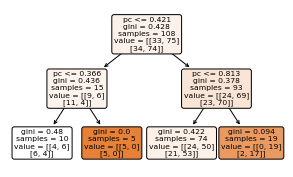

  1%|▍                                           | 1/89 [00:00<00:25,  3.52it/s]

1
Node_1
(10, 19)
(4, 19)
LR Model
4
4
Node_2
(5, 19)
(5, 19)
LR Model
9
9
Node_3
(74, 19)
(36, 19)
LR Model
45
45
Node_4
(19, 19)
(10, 19)
LR Model
55
55
178_684
Assay:  180_686
Inactive Compounds  122
Active Compounds  41
Inactive Compounds (after Undersamplimg)  41
Total Compounds (after Undersamplimg)  82
82
41
Herirachal model for training data


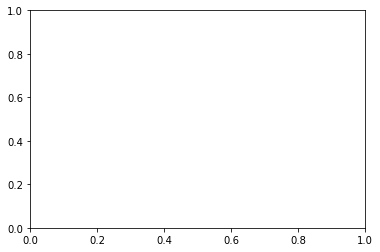

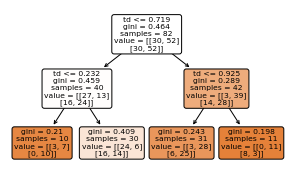

  2%|▉                                           | 2/89 [00:00<00:27,  3.20it/s]

2
Node_1
(10, 19)
(1, 19)
LR Model
1
1
Node_2
(30, 19)
(10, 19)
LR Model
11
11
Node_3
(31, 19)
(28, 19)
LR Model
39
39
Node_4
(11, 19)
(2, 19)
only positive variables in train but test compounds present, take average:
180_686
Assay:  183_604
Inactive Compounds  108
Active Compounds  36
Inactive Compounds (after Undersamplimg)  36
Total Compounds (after Undersamplimg)  72
72
36
Herirachal model for training data


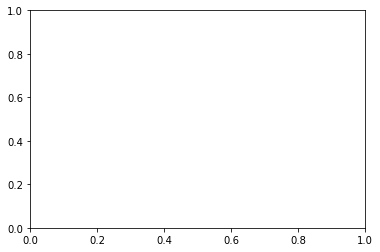

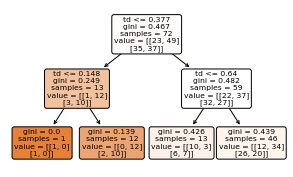

  3%|█▍                                          | 3/89 [00:00<00:27,  3.11it/s]

3
Node_1
(1, 19)
(1, 19)
only negative variables in train but test compounds present, take average:
Node_2
(12, 19)
(3, 19)
only positive variables in train but test compounds present, take average:
Node_3
(13, 19)
(1, 19)
LR Model
5
5
Node_4
(46, 19)
(31, 19)
LR Model
36
36
183_604
Assay:  184_606
Inactive Compounds  187
Active Compounds  62
Inactive Compounds (after Undersamplimg)  62
Total Compounds (after Undersamplimg)  124
124
63
Herirachal model for training data


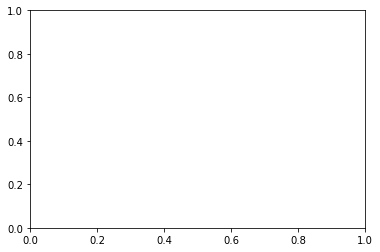

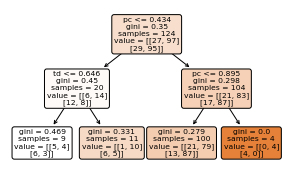

  4%|█▉                                          | 4/89 [00:01<00:27,  3.07it/s]

4
Node_1
(9, 19)
(1, 19)
LR Model
1
1
Node_2
(11, 19)
(7, 19)
LR Model
8
8
Node_3
(100, 19)
(52, 19)
LR Model
60
60
Node_4
(4, 19)
(3, 19)
only negative variables in train but test compounds present, take average:
184_606
Assay:  185_665
Inactive Compounds  72
Active Compounds  24
Inactive Compounds (after Undersamplimg)  24
Total Compounds (after Undersamplimg)  48
48
24
Herirachal model for training data


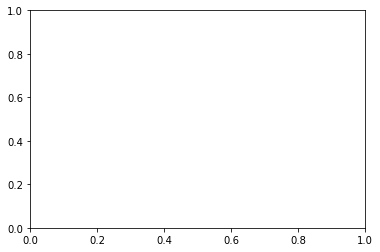

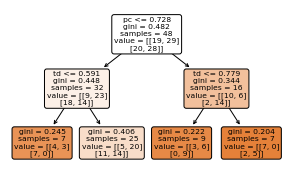

  6%|██▍                                         | 5/89 [00:01<00:27,  3.03it/s]

5
Node_1
(7, 19)
(2, 19)
LR Model
2
2
Node_2
(25, 19)
(11, 19)
LR Model
13
13
Node_3
(9, 19)
(3, 19)
LR Model
16
16
Node_4
(7, 19)
(8, 19)
only negative variables in train but test compounds present, take average:
185_665
Assay:  185_666
Inactive Compounds  103
Active Compounds  34
Inactive Compounds (after Undersamplimg)  34
Total Compounds (after Undersamplimg)  68
68
35
Herirachal model for training data


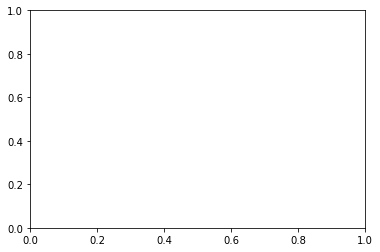

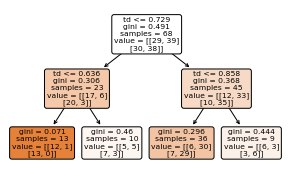

  7%|██▉                                         | 6/89 [00:01<00:27,  3.01it/s]

6
Node_1
(13, 19)
(4, 19)
LR Model
4
4
Node_2
(10, 19)
(7, 19)
LR Model
11
11
Node_3
(36, 19)
(14, 19)
LR Model
25
25
Node_4
(9, 19)
(10, 19)
LR Model
35
35
185_666
Assay:  186_668
Inactive Compounds  76
Active Compounds  26
Inactive Compounds (after Undersamplimg)  26
Total Compounds (after Undersamplimg)  52
52
26
Herirachal model for training data


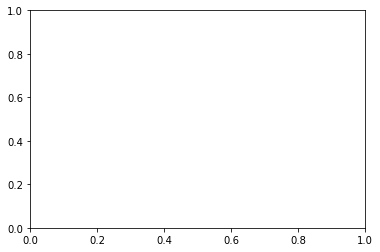

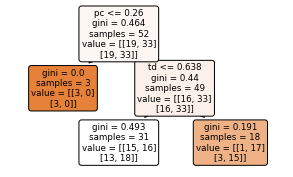

  8%|███▍                                        | 7/89 [00:02<00:27,  2.95it/s]

7
Node_1
(3, 19)
(1, 19)
only positive variables in train but test compounds present, take average:
Node_2
(31, 19)
(11, 19)
LR Model
12
12
Node_3
(18, 19)
(14, 19)
LR Model
26
26
Node_4
(0, 19)
(0, 19)
26
26
186_668
Assay:  190_628
Inactive Compounds  93
Active Compounds  31
Inactive Compounds (after Undersamplimg)  31
Total Compounds (after Undersamplimg)  62
62
32
Herirachal model for training data


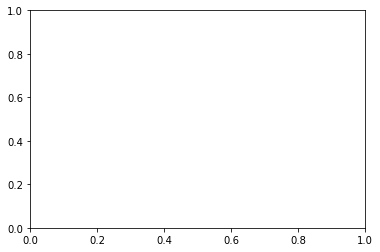

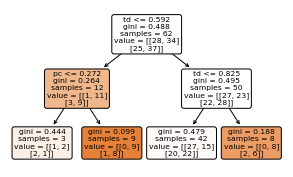

  9%|███▉                                        | 8/89 [00:02<00:27,  2.95it/s]

8
Node_1
(3, 19)
(0, 19)
0
0
Node_2
(9, 19)
(5, 19)
only positive variables in train but test compounds present, take average:
Node_3
(42, 19)
(14, 19)
LR Model
19
19
Node_4
(8, 19)
(13, 19)
only negative variables in train but test compounds present, take average:
190_628
Assay:  190_629
Inactive Compounds  62
Active Compounds  21
Inactive Compounds (after Undersamplimg)  21
Total Compounds (after Undersamplimg)  42
42
21
Herirachal model for training data


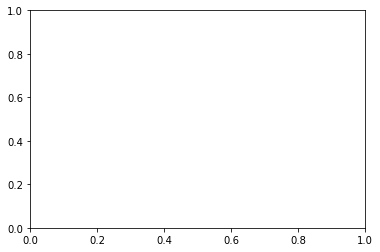

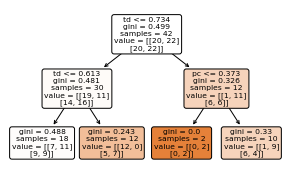

 10%|████▍                                       | 9/89 [00:02<00:27,  2.96it/s]

9
Node_1
(18, 19)
(9, 19)
only positive variables in train but test compounds present, take average:
Node_2
(12, 19)
(9, 19)
LR Model
18
18
Node_3
(2, 19)
(0, 19)
18
18
Node_4
(10, 19)
(3, 19)
only negative variables in train but test compounds present, take average:
190_629
Assay:  190_674
Inactive Compounds  74
Active Compounds  25
Inactive Compounds (after Undersamplimg)  25
Total Compounds (after Undersamplimg)  50
50
25
Herirachal model for training data


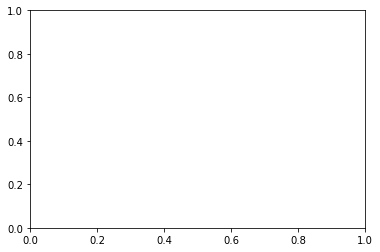

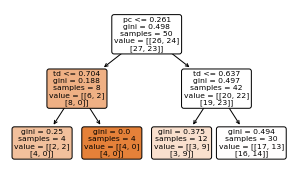

 11%|████▊                                      | 10/89 [00:03<00:26,  2.99it/s]

10
Node_1
(4, 19)
(0, 19)
0
0
Node_2
(4, 19)
(4, 19)
only positive variables in train but test compounds present, take average:
Node_3
(12, 19)
(4, 19)
LR Model
8
8
Node_4
(30, 19)
(17, 19)
LR Model
25
25
190_674
Assay:  191_630
Inactive Compounds  110
Active Compounds  37
Inactive Compounds (after Undersamplimg)  37
Total Compounds (after Undersamplimg)  74
74
37
Herirachal model for training data


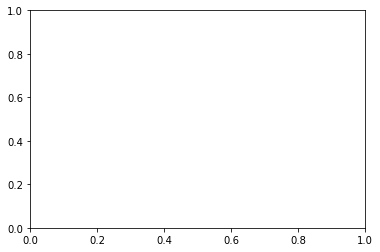

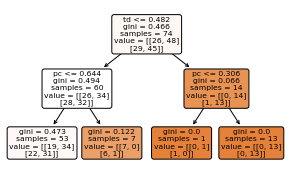

 12%|█████▎                                     | 11/89 [00:03<00:26,  2.97it/s]

11
Node_1
(53, 19)
(24, 19)
LR Model
24
24
Node_2
(7, 19)
(7, 19)
LR Model
31
31
Node_3
(1, 19)
(0, 19)
31
31
Node_4
(13, 19)
(6, 19)
only negative variables in train but test compounds present, take average:
191_630
Assay:  191_631
Inactive Compounds  98
Active Compounds  33
Inactive Compounds (after Undersamplimg)  33
Total Compounds (after Undersamplimg)  66
66
33
Herirachal model for training data


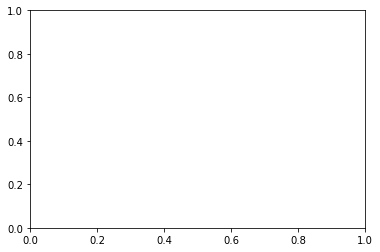

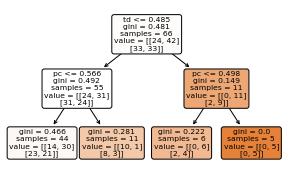

 13%|█████▊                                     | 12/89 [00:03<00:26,  2.96it/s]

12
Node_1
(44, 19)
(16, 19)
LR Model
16
16
Node_2
(11, 19)
(10, 19)
LR Model
26
26
Node_3
(6, 19)
(3, 19)
only negative variables in train but test compounds present, take average:
Node_4
(5, 19)
(4, 19)
only negative variables in train but test compounds present, take average:
191_631
Assay:  193_723
Inactive Compounds  120
Active Compounds  40
Inactive Compounds (after Undersamplimg)  40
Total Compounds (after Undersamplimg)  80
80
40
Herirachal model for training data


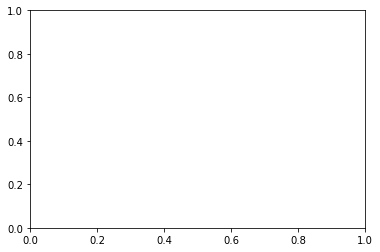

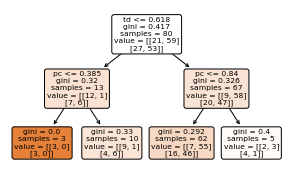

 15%|██████▎                                    | 13/89 [00:04<00:25,  2.98it/s]

13
Node_1
(3, 19)
(0, 19)
0
0
Node_2
(10, 19)
(1, 19)
LR Model
1
1
Node_3
(62, 19)
(39, 19)
LR Model
40
40
Node_4
(5, 19)
(0, 19)
40
40
193_723
Assay:  194_639
Inactive Compounds  141
Active Compounds  47
Inactive Compounds (after Undersamplimg)  47
Total Compounds (after Undersamplimg)  94
94
48
Herirachal model for training data


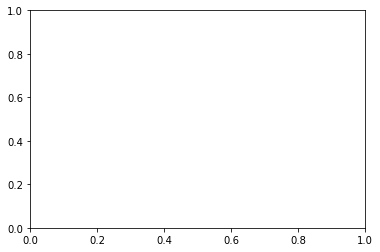

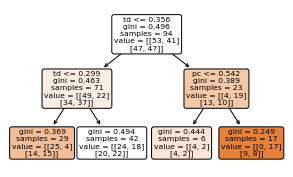

 16%|██████▊                                    | 14/89 [00:04<00:27,  2.76it/s]

14
Node_1
(29, 19)
(6, 19)
LR Model
6
6
Node_2
(42, 19)
(11, 19)
LR Model
17
17
Node_3
(6, 19)
(9, 19)
LR Model
26
26
Node_4
(17, 19)
(22, 19)
only negative variables in train but test compounds present, take average:
194_639
Assay:  195_642
Inactive Compounds  321
Active Compounds  107
Inactive Compounds (after Undersamplimg)  107
Total Compounds (after Undersamplimg)  214
214
108
Herirachal model for training data


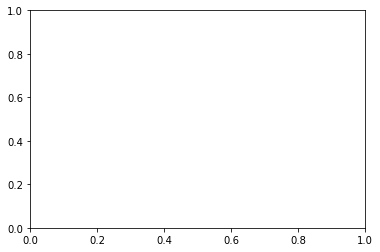

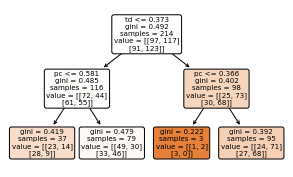

 17%|███████▏                                   | 15/89 [00:05<00:26,  2.80it/s]

15
Node_1
(37, 19)
(10, 19)
LR Model
10
10
Node_2
(79, 19)
(31, 19)
LR Model
41
41
Node_3
(3, 19)
(1, 19)
LR Model
42
42
Node_4
(95, 19)
(66, 19)
LR Model
108
108
195_642
Assay:  197_645
Inactive Compounds  204
Active Compounds  68
Inactive Compounds (after Undersamplimg)  68
Total Compounds (after Undersamplimg)  136
136
68
Herirachal model for training data


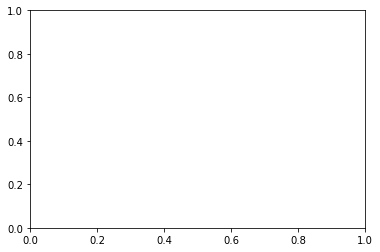

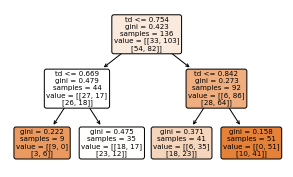

 18%|███████▋                                   | 16/89 [00:05<00:25,  2.85it/s]

16
Node_1
(9, 19)
(6, 19)
LR Model
6
6
Node_2
(35, 19)
(6, 19)
LR Model
12
12
Node_3
(41, 19)
(12, 19)
LR Model
24
24
Node_4
(51, 19)
(44, 19)
LR Model
68
68
197_645
Assay:  197_646
Inactive Compounds  74
Active Compounds  25
Inactive Compounds (after Undersamplimg)  25
Total Compounds (after Undersamplimg)  50
50
25
Herirachal model for training data


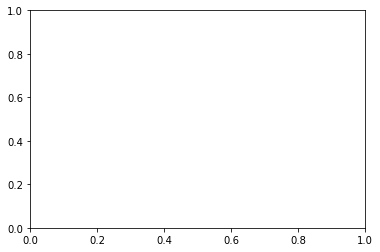

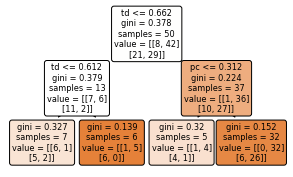

 19%|████████▏                                  | 17/89 [00:05<00:25,  2.85it/s]

17
Node_1
(7, 19)
(3, 19)
LR Model
3
3
Node_2
(6, 19)
(2, 19)
LR Model
5
5
Node_3
(5, 19)
(1, 19)
LR Model
6
6
Node_4
(32, 19)
(19, 19)
LR Model
25
25
197_646
Assay:  197_649
Inactive Compounds  499
Active Compounds  166
Inactive Compounds (after Undersamplimg)  166
Total Compounds (after Undersamplimg)  332
332
167
Herirachal model for training data


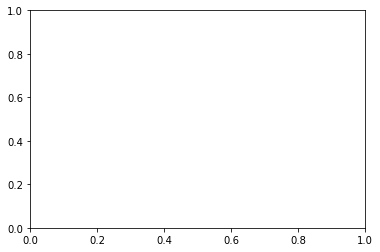

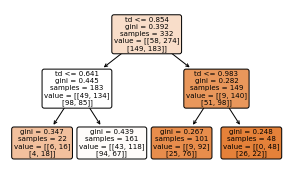

 20%|████████▋                                  | 18/89 [00:06<00:25,  2.84it/s]

18
Node_1
(22, 19)
(9, 19)
LR Model
9
9
Node_2
(161, 19)
(58, 19)
LR Model
67
67
Node_3
(101, 19)
(68, 19)
LR Model
135
135
Node_4
(48, 19)
(32, 19)
LR Model
167
167
197_649
Assay:  197_650
Inactive Compounds  216
Active Compounds  72
Inactive Compounds (after Undersamplimg)  72
Total Compounds (after Undersamplimg)  144
144
72
Herirachal model for training data


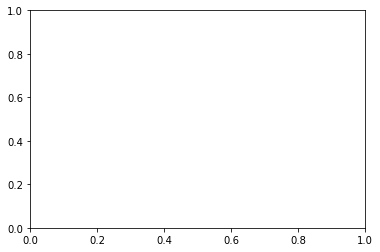

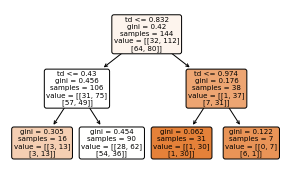

 21%|█████████▏                                 | 19/89 [00:06<00:24,  2.87it/s]

19
Node_1
(16, 19)
(5, 19)
LR Model
5
5
Node_2
(90, 19)
(30, 19)
LR Model
35
35
Node_3
(31, 19)
(32, 19)
only negative variables in train but test compounds present, take average:
Node_4
(7, 19)
(5, 19)
only positive variables in train but test compounds present, take average:
197_650
Assay:  198_682
Inactive Compounds  292
Active Compounds  98
Inactive Compounds (after Undersamplimg)  98
Total Compounds (after Undersamplimg)  196
196
98
Herirachal model for training data


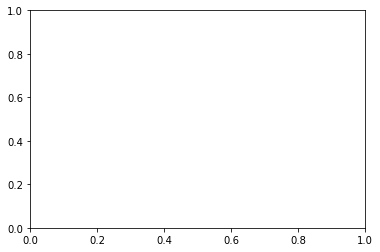

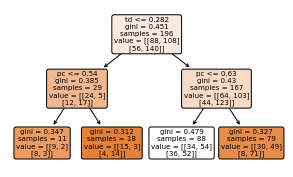

 22%|█████████▋                                 | 20/89 [00:06<00:23,  2.91it/s]

20
Node_1
(11, 19)
(0, 19)
Node_2
(18, 19)
(4, 19)
LR Model
4
4
Node_3
(88, 19)
(39, 19)
LR Model
43
43
Node_4
(79, 19)
(55, 19)
LR Model
98
98
198_682
Assay:  199_657
Inactive Compounds  139
Active Compounds  46
Inactive Compounds (after Undersamplimg)  46
Total Compounds (after Undersamplimg)  92
92
47
Herirachal model for training data


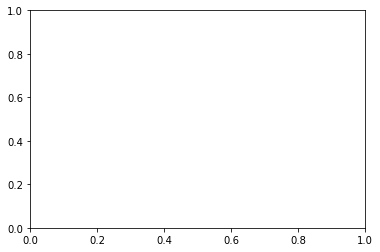

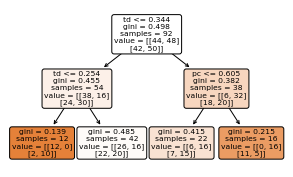

 24%|██████████▏                                | 21/89 [00:07<00:24,  2.81it/s]

21
Node_1
(12, 19)
(4, 19)
LR Model
4
4
Node_2
(42, 19)
(18, 19)
LR Model
22
22
Node_3
(22, 19)
(13, 19)
LR Model
35
35
Node_4
(16, 19)
(12, 19)
LR Model
47
47
199_657
Assay:  202_661
Inactive Compounds  103
Active Compounds  34
Inactive Compounds (after Undersamplimg)  34
Total Compounds (after Undersamplimg)  68
68
35
Herirachal model for training data


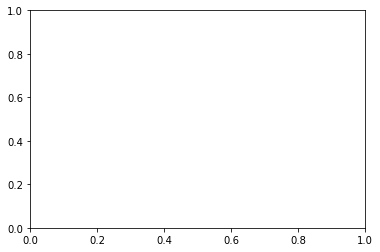

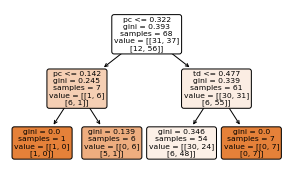

 25%|██████████▋                                | 22/89 [00:07<00:23,  2.86it/s]

22
Node_1
(1, 19)
(0, 19)
0
0
Node_2
(6, 19)
(3, 19)
LR Model
3
3
Node_3
(54, 19)
(25, 19)
LR Model
28
28
Node_4
(7, 19)
(7, 19)
only negative variables in train but test compounds present, take average:
202_661
Assay:  205_664
Inactive Compounds  552
Active Compounds  184
Inactive Compounds (after Undersamplimg)  184
Total Compounds (after Undersamplimg)  368
368
184
Herirachal model for training data


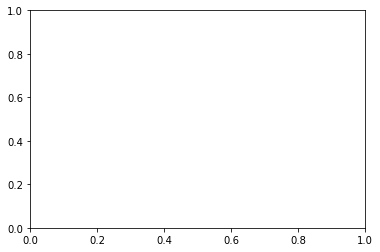

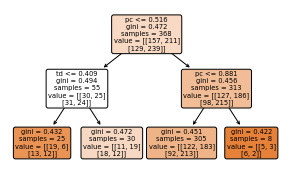

 26%|███████████                                | 23/89 [00:07<00:23,  2.86it/s]

23
Node_1
(25, 19)
(7, 19)
LR Model
7
7
Node_2
(30, 19)
(22, 19)
LR Model
29
29
Node_3
(305, 19)
(152, 19)
LR Model
181
181
Node_4
(8, 19)
(3, 19)
LR Model
184
184
205_664
Assay:  206_670
Inactive Compounds  86
Active Compounds  29
Inactive Compounds (after Undersamplimg)  29
Total Compounds (after Undersamplimg)  58
58
29
Herirachal model for training data


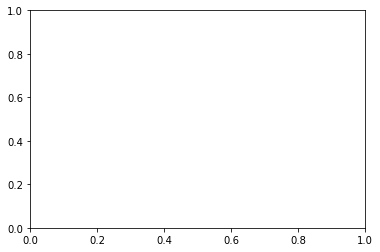

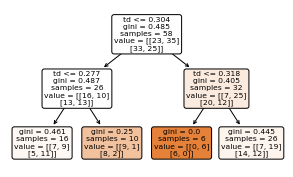

 27%|███████████▌                               | 24/89 [00:08<00:22,  2.90it/s]

24
Node_1
(16, 19)
(3, 19)
LR Model
3
3
Node_2
(10, 19)
(5, 19)
LR Model
8
8
Node_3
(6, 19)
(4, 19)
LR Model
12
12
Node_4
(26, 19)
(17, 19)
LR Model
29
29
206_670
Assay:  206_671
Inactive Compounds  115
Active Compounds  38
Inactive Compounds (after Undersamplimg)  38
Total Compounds (after Undersamplimg)  76
76
39
Herirachal model for training data


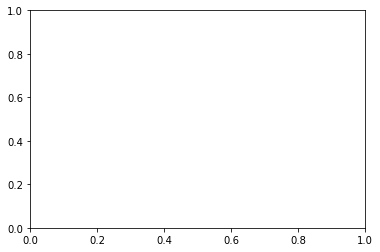

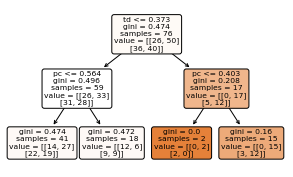

 28%|████████████                               | 25/89 [00:08<00:21,  2.92it/s]

25
Node_1
(41, 19)
(13, 19)
LR Model
13
13
Node_2
(18, 19)
(17, 19)
LR Model
30
30
Node_3
(2, 19)
(0, 19)
30
30
Node_4
(15, 19)
(9, 19)
LR Model
39
39
206_671
Assay:  207_672
Inactive Compounds  230
Active Compounds  77
Inactive Compounds (after Undersamplimg)  77
Total Compounds (after Undersamplimg)  154
154
77
Herirachal model for training data


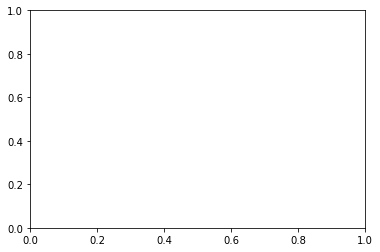

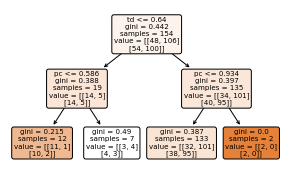

 29%|████████████▌                              | 26/89 [00:08<00:21,  2.93it/s]

26
Node_1
(12, 19)
(0, 19)
Node_2
(7, 19)
(1, 19)
LR Model
1
1
Node_3
(133, 19)
(76, 19)
LR Model
77
77
Node_4
(2, 19)
(0, 19)
77
77
207_672
Assay:  208_673
Inactive Compounds  74
Active Compounds  25
Inactive Compounds (after Undersamplimg)  25
Total Compounds (after Undersamplimg)  50
50
25
Herirachal model for training data


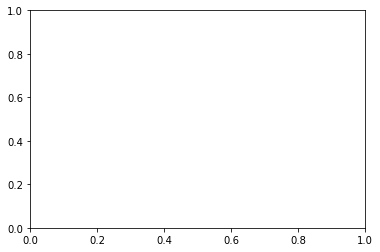

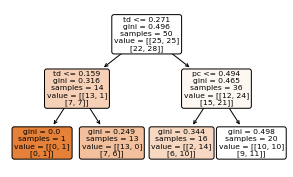

 30%|█████████████                              | 27/89 [00:09<00:21,  2.95it/s]

27
Node_1
(1, 19)
(0, 19)
0
0
Node_2
(13, 19)
(3, 19)
LR Model
3
3
Node_3
(16, 19)
(7, 19)
LR Model
10
10
Node_4
(20, 19)
(15, 19)
LR Model
25
25
208_673
Assay:  210_677
Inactive Compounds  230
Active Compounds  77
Inactive Compounds (after Undersamplimg)  77
Total Compounds (after Undersamplimg)  154
154
77
Herirachal model for training data


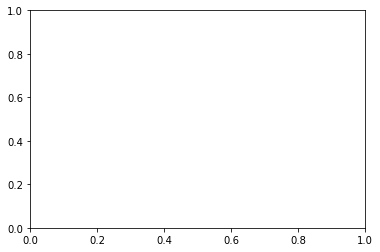

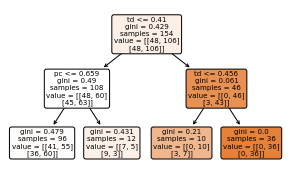

 31%|█████████████▌                             | 28/89 [00:09<00:21,  2.79it/s]

28
Node_1
(96, 19)
(35, 19)
LR Model
35
35
Node_2
(12, 19)
(8, 19)
LR Model
43
43
Node_3
(10, 19)
(6, 19)
only positive variables in train but test compounds present, take average:
Node_4
(36, 19)
(28, 19)
LR Model
77
77
210_677
Assay:  213_681
Inactive Compounds  288
Active Compounds  96
Inactive Compounds (after Undersamplimg)  96
Total Compounds (after Undersamplimg)  192
192
96
Herirachal model for training data


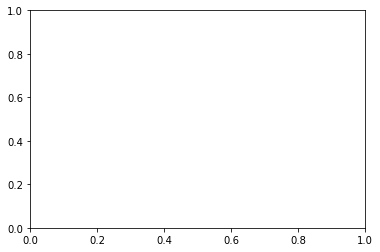

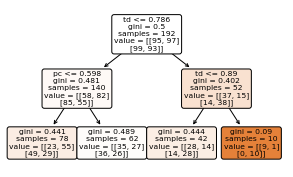

 33%|██████████████                             | 29/89 [00:09<00:21,  2.84it/s]

29
Node_1
(78, 19)
(32, 19)
LR Model
32
32
Node_2
(62, 19)
(28, 19)
LR Model
60
60
Node_3
(42, 19)
(28, 19)
LR Model
88
88
Node_4
(10, 19)
(8, 19)
only negative variables in train but test compounds present, take average:
213_681
Assay:  214_683
Inactive Compounds  72
Active Compounds  24
Inactive Compounds (after Undersamplimg)  24
Total Compounds (after Undersamplimg)  48
48
24
Herirachal model for training data


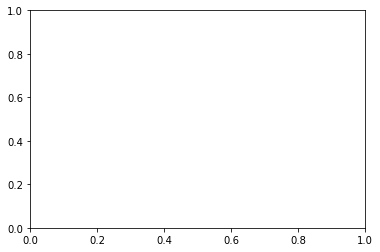

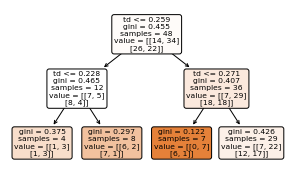

 34%|██████████████▍                            | 30/89 [00:10<00:20,  2.91it/s]

30
Node_1
(4, 19)
(1, 19)
LR Model
1
1
Node_2
(8, 19)
(2, 19)
LR Model
3
3
Node_3
(7, 19)
(1, 19)
only positive variables in train but test compounds present, take average:
Node_4
(29, 19)
(20, 19)
LR Model
24
24
214_683
Assay:  215_685
Inactive Compounds  266
Active Compounds  89
Inactive Compounds (after Undersamplimg)  89
Total Compounds (after Undersamplimg)  178
178
89
Herirachal model for training data


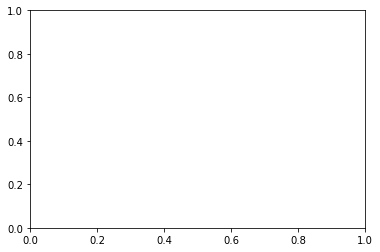

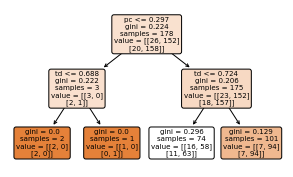

 35%|██████████████▉                            | 31/89 [00:10<00:19,  2.92it/s]

31
Node_1
(2, 19)
(1, 19)
LR Model
1
1
Node_2
(1, 19)
(1, 19)
only positive variables in train but test compounds present, take average:
Node_3
(74, 19)
(32, 19)
LR Model
34
34
Node_4
(101, 19)
(55, 19)
LR Model
89
89
215_685
Assay:  217_688
Inactive Compounds  427
Active Compounds  142
Inactive Compounds (after Undersamplimg)  142
Total Compounds (after Undersamplimg)  284
284
143
Herirachal model for training data


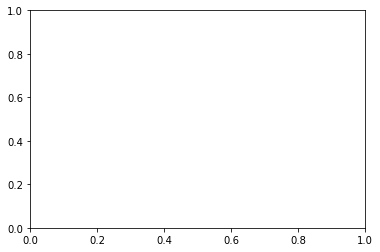

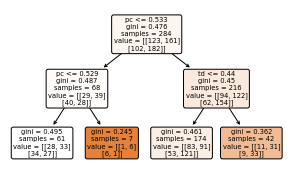

 36%|███████████████▍                           | 32/89 [00:10<00:19,  2.92it/s]

32
Node_1
(61, 19)
(20, 19)
LR Model
20
20
Node_2
(7, 19)
(0, 19)
Node_3
(174, 19)
(91, 19)
LR Model
111
111
Node_4
(42, 19)
(32, 19)
LR Model
143
143
217_688
Assay:  217_689
Inactive Compounds  163
Active Compounds  54
Inactive Compounds (after Undersamplimg)  54
Total Compounds (after Undersamplimg)  108
108
55
Herirachal model for training data


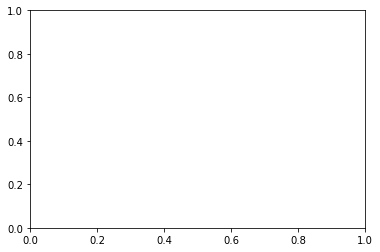

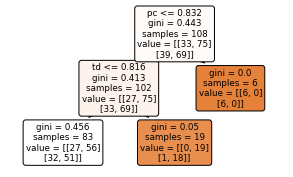

 37%|███████████████▉                           | 33/89 [00:11<00:17,  3.14it/s]

33
Node_1
(83, 19)
(30, 19)
LR Model
30
30
Node_2
(19, 19)
(23, 19)
LR Model
53
53
Node_3
(6, 19)
(2, 19)
only negative variables in train but test compounds present, take average:
Node_4
(0, 19)
(0, 19)
55
55
217_689
Assay:  219_691
Inactive Compounds  79
Active Compounds  26
Inactive Compounds (after Undersamplimg)  26
Total Compounds (after Undersamplimg)  52
52
27
Herirachal model for training data


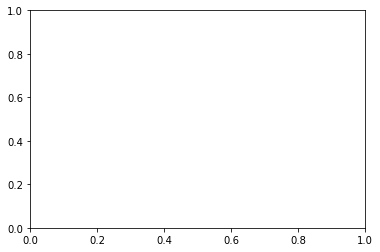

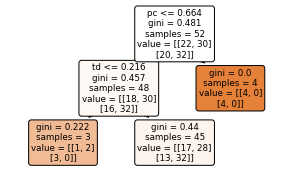

 38%|████████████████▍                          | 34/89 [00:11<00:16,  3.25it/s]

34
Node_1
(3, 19)
(1, 19)
LR Model
1
1
Node_2
(45, 19)
(20, 19)
LR Model
21
21
Node_3
(4, 19)
(6, 19)
LR Model
27
27
Node_4
(0, 19)
(0, 19)
27
27
219_691
Assay:  220_692
Inactive Compounds  655
Active Compounds  218
Inactive Compounds (after Undersamplimg)  218
Total Compounds (after Undersamplimg)  436
436
219
Herirachal model for training data


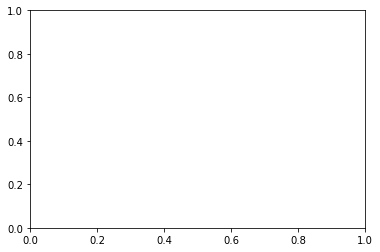

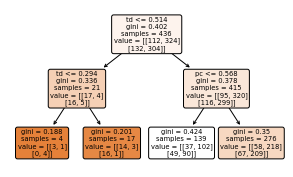

 39%|████████████████▉                          | 35/89 [00:11<00:18,  2.95it/s]

35
Node_1
(4, 19)
(2, 19)
LR Model
2
2
Node_2
(17, 19)
(1, 19)
LR Model
3
3
Node_3
(139, 19)
(73, 19)
LR Model
76
76
Node_4
(276, 19)
(143, 19)
LR Model
219
219
220_692
Assay:  221_693
Inactive Compounds  1034
Active Compounds  345
Inactive Compounds (after Undersamplimg)  345
Total Compounds (after Undersamplimg)  690
690
345
Herirachal model for training data


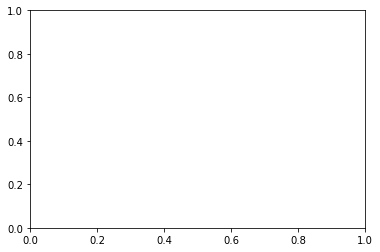

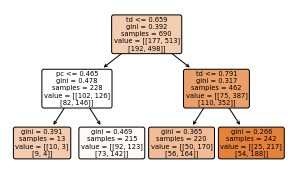

 40%|█████████████████▍                         | 36/89 [00:12<00:18,  2.90it/s]

36
Node_1
(13, 19)
(6, 19)
LR Model
6
6
Node_2
(215, 19)
(76, 19)
LR Model
82
82
Node_3
(220, 19)
(129, 19)
LR Model
211
211
Node_4
(242, 19)
(134, 19)
LR Model
345
345
221_693
Assay:  223_695
Inactive Compounds  76
Active Compounds  26
Inactive Compounds (after Undersamplimg)  26
Total Compounds (after Undersamplimg)  52
52
26
Herirachal model for training data


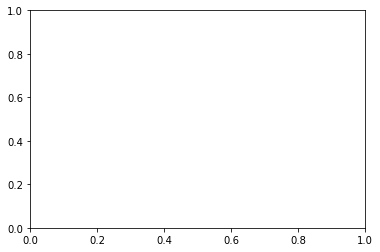

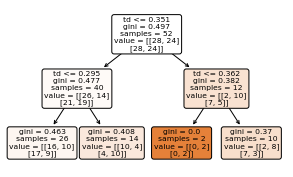

 42%|█████████████████▉                         | 37/89 [00:12<00:17,  2.94it/s]

37
Node_1
(26, 19)
(11, 19)
LR Model
11
11
Node_2
(14, 19)
(5, 19)
LR Model
16
16
Node_3
(2, 19)
(4, 19)
only positive variables in train but test compounds present, take average:
Node_4
(10, 19)
(6, 19)
LR Model
26
26
223_695
Assay:  224_696
Inactive Compounds  237
Active Compounds  79
Inactive Compounds (after Undersamplimg)  79
Total Compounds (after Undersamplimg)  158
158
80
Herirachal model for training data


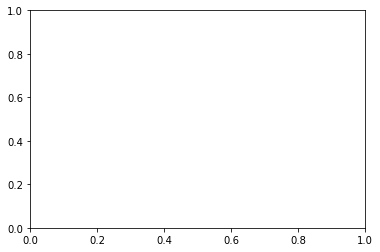

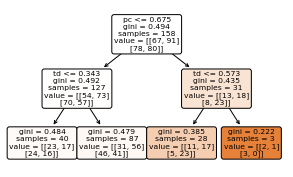

 43%|██████████████████▎                        | 38/89 [00:12<00:17,  2.94it/s]

38
Node_1
(40, 19)
(14, 19)
LR Model
14
14
Node_2
(87, 19)
(48, 19)
LR Model
62
62
Node_3
(28, 19)
(18, 19)
LR Model
80
80
Node_4
(3, 19)
(0, 19)
80
80
224_696
Assay:  228_700
Inactive Compounds  139
Active Compounds  46
Inactive Compounds (after Undersamplimg)  46
Total Compounds (after Undersamplimg)  92
92
47
Herirachal model for training data


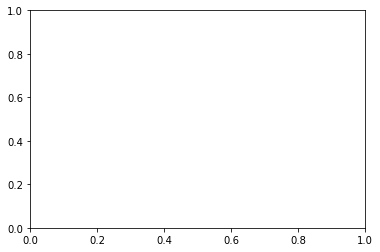

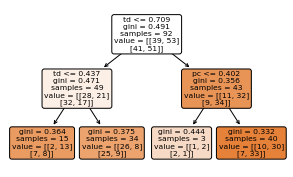

 44%|██████████████████▊                        | 39/89 [00:13<00:16,  2.95it/s]

39
Node_1
(15, 19)
(2, 19)
LR Model
2
2
Node_2
(34, 19)
(7, 19)
LR Model
9
9
Node_3
(3, 19)
(5, 19)
LR Model
14
14
Node_4
(40, 19)
(33, 19)
LR Model
47
47
228_700
Assay:  229_701
Inactive Compounds  765
Active Compounds  255
Inactive Compounds (after Undersamplimg)  255
Total Compounds (after Undersamplimg)  510
510
256
Herirachal model for training data


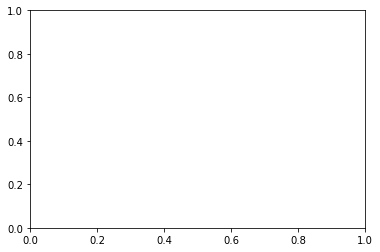

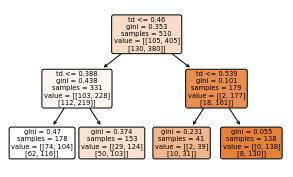

 45%|███████████████████▎                       | 40/89 [00:13<00:16,  2.92it/s]

40
Node_1
(178, 19)
(50, 19)
LR Model
50
50
Node_2
(153, 19)
(69, 19)
LR Model
119
119
Node_3
(41, 19)
(23, 19)
LR Model
142
142
Node_4
(138, 19)
(114, 19)
LR Model
256
256
229_701
Assay:  230_702
Inactive Compounds  98
Active Compounds  33
Inactive Compounds (after Undersamplimg)  33
Total Compounds (after Undersamplimg)  66
66
33
Herirachal model for training data


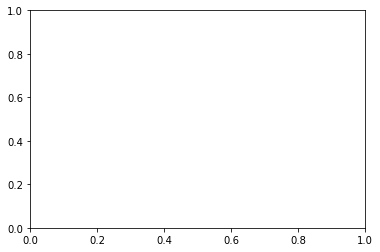

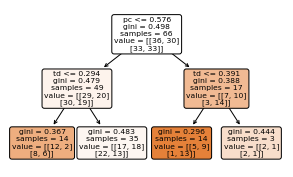

 46%|███████████████████▊                       | 41/89 [00:13<00:16,  2.94it/s]

41
Node_1
(14, 19)
(5, 19)
LR Model
5
5
Node_2
(35, 19)
(10, 19)
LR Model
15
15
Node_3
(14, 19)
(13, 19)
LR Model
28
28
Node_4
(3, 19)
(5, 19)
only negative variables in train but test compounds present, take average:
230_702
Assay:  231_703
Inactive Compounds  672
Active Compounds  224
Inactive Compounds (after Undersamplimg)  224
Total Compounds (after Undersamplimg)  448
448
224
Herirachal model for training data


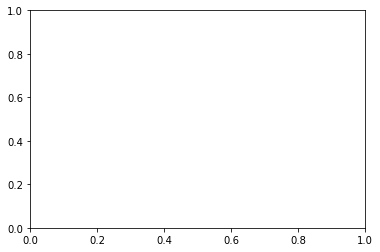

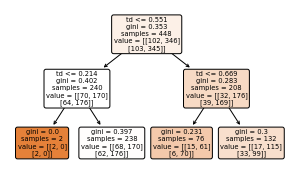

 47%|████████████████████▎                      | 42/89 [00:14<00:16,  2.78it/s]

42
Node_1
(2, 19)
(0, 19)
0
0
Node_2
(238, 19)
(74, 19)
LR Model
74
74
Node_3
(76, 19)
(41, 19)
LR Model
115
115
Node_4
(132, 19)
(109, 19)
LR Model
224
224
231_703
Assay:  232_704
Inactive Compounds  367
Active Compounds  122
Inactive Compounds (after Undersamplimg)  122
Total Compounds (after Undersamplimg)  244
244
123
Herirachal model for training data


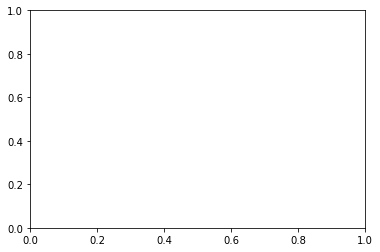

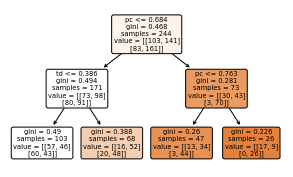

 48%|████████████████████▊                      | 43/89 [00:14<00:16,  2.79it/s]

43
Node_1
(103, 19)
(34, 19)
LR Model
34
34
Node_2
(68, 19)
(42, 19)
LR Model
76
76
Node_3
(47, 19)
(35, 19)
LR Model
111
111
Node_4
(26, 19)
(12, 19)
LR Model
123
123
232_704
Assay:  232_705
Inactive Compounds  177
Active Compounds  59
Inactive Compounds (after Undersamplimg)  59
Total Compounds (after Undersamplimg)  118
118
60
Herirachal model for training data


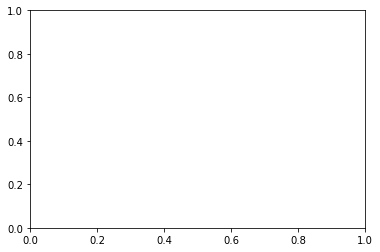

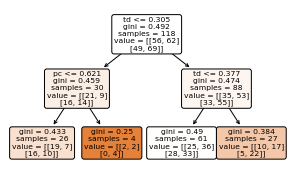

 49%|█████████████████████▎                     | 44/89 [00:15<00:15,  2.84it/s]

44
Node_1
(26, 19)
(9, 19)
LR Model
9
9
Node_2
(4, 19)
(2, 19)
LR Model
11
11
Node_3
(61, 19)
(28, 19)
LR Model
39
39
Node_4
(27, 19)
(21, 19)
LR Model
60
60
232_705
Assay:  233_706
Inactive Compounds  434
Active Compounds  145
Inactive Compounds (after Undersamplimg)  145
Total Compounds (after Undersamplimg)  290
290
145
Herirachal model for training data


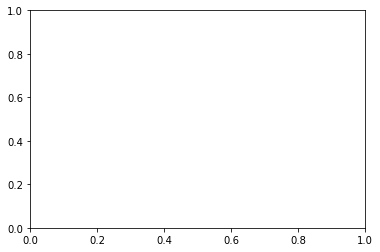

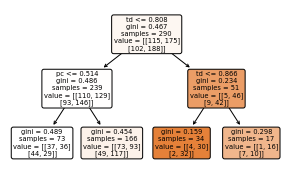

 51%|█████████████████████▋                     | 45/89 [00:15<00:15,  2.89it/s]

45
Node_1
(73, 19)
(36, 19)
LR Model
36
36
Node_2
(166, 19)
(83, 19)
LR Model
119
119
Node_3
(34, 19)
(17, 19)
LR Model
136
136
Node_4
(17, 19)
(9, 19)
LR Model
145
145
233_706
Assay:  234_707
Inactive Compounds  1233
Active Compounds  411
Inactive Compounds (after Undersamplimg)  411
Total Compounds (after Undersamplimg)  822
822
412
Herirachal model for training data


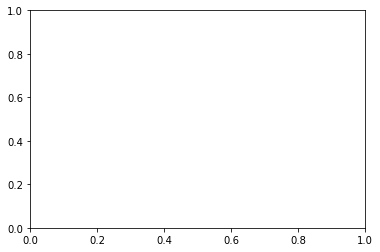

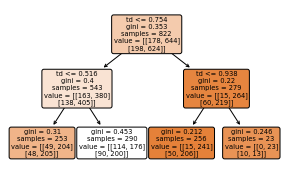

 52%|██████████████████████▏                    | 46/89 [00:15<00:15,  2.85it/s]

46
Node_1
(253, 19)
(71, 19)
LR Model
71
71
Node_2
(290, 19)
(142, 19)
LR Model
213
213
Node_3
(256, 19)
(174, 19)
LR Model
387
387
Node_4
(23, 19)
(25, 19)
LR Model
412
412
234_707
Assay:  235_708
Inactive Compounds  1060
Active Compounds  354
Inactive Compounds (after Undersamplimg)  354
Total Compounds (after Undersamplimg)  708
708
354
Herirachal model for training data


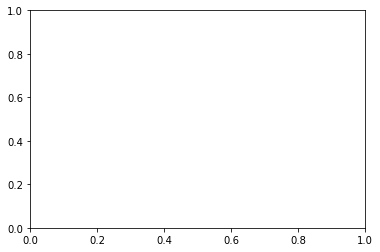

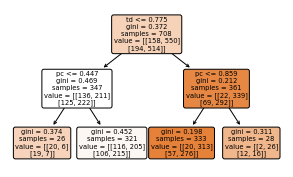

 53%|██████████████████████▋                    | 47/89 [00:16<00:14,  2.85it/s]

47
Node_1
(26, 19)
(13, 19)
LR Model
13
13
Node_2
(321, 19)
(148, 19)
LR Model
161
161
Node_3
(333, 19)
(175, 19)
LR Model
336
336
Node_4
(28, 19)
(18, 19)
LR Model
354
354
235_708
Assay:  236_709
Inactive Compounds  504
Active Compounds  168
Inactive Compounds (after Undersamplimg)  168
Total Compounds (after Undersamplimg)  336
336
168
Herirachal model for training data


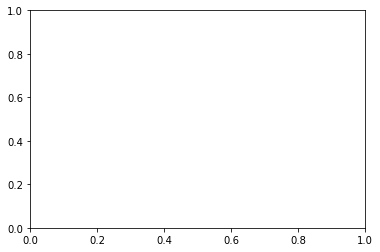

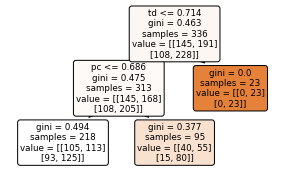

 54%|███████████████████████▏                   | 48/89 [00:16<00:13,  3.04it/s]

48
Node_1
(218, 19)
(92, 19)
LR Model
92
92
Node_2
(95, 19)
(66, 19)
LR Model
158
158
Node_3
(23, 19)
(10, 19)
only negative variables in train but test compounds present, take average:
Node_4
(0, 19)
(0, 19)
168
168
236_709
Assay:  237_710
Inactive Compounds  112
Active Compounds  38
Inactive Compounds (after Undersamplimg)  38
Total Compounds (after Undersamplimg)  76
76
38
Herirachal model for training data


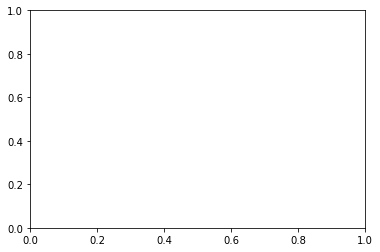

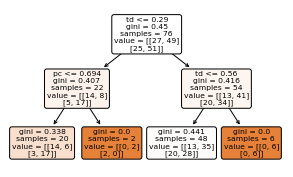

 55%|███████████████████████▋                   | 49/89 [00:16<00:14,  2.83it/s]

49
Node_1
(20, 19)
(6, 19)
LR Model
6
6
Node_2
(2, 19)
(1, 19)
only negative variables in train but test compounds present, take average:
Node_3
(48, 19)
(31, 19)
LR Model
38
38
Node_4
(6, 19)
(0, 19)
38
38
237_710
Assay:  238_712
Inactive Compounds  1281
Active Compounds  427
Inactive Compounds (after Undersamplimg)  427
Total Compounds (after Undersamplimg)  854
854
428
Herirachal model for training data


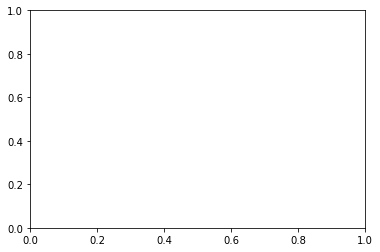

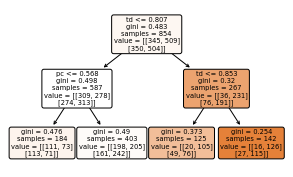

 56%|████████████████████████▏                  | 50/89 [00:17<00:13,  2.84it/s]

50
Node_1
(184, 19)
(58, 19)
LR Model
58
58
Node_2
(403, 19)
(194, 19)
LR Model
252
252
Node_3
(125, 19)
(81, 19)
LR Model
333
333
Node_4
(142, 19)
(95, 19)
LR Model
428
428
238_712
Assay:  239_713
Inactive Compounds  436
Active Compounds  146
Inactive Compounds (after Undersamplimg)  146
Total Compounds (after Undersamplimg)  292
292
146
Herirachal model for training data


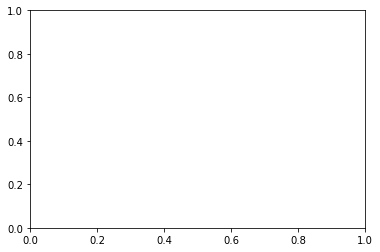

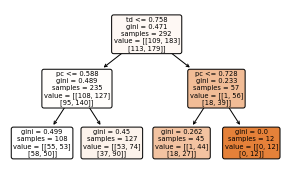

 57%|████████████████████████▋                  | 51/89 [00:17<00:13,  2.87it/s]

51
Node_1
(108, 19)
(44, 19)
LR Model
44
44
Node_2
(127, 19)
(63, 19)
LR Model
107
107
Node_3
(45, 19)
(34, 19)
LR Model
141
141
Node_4
(12, 19)
(5, 19)
LR Model
146
146
239_713
Assay:  240_714
Inactive Compounds  1269
Active Compounds  423
Inactive Compounds (after Undersamplimg)  423
Total Compounds (after Undersamplimg)  846
846
424
Herirachal model for training data


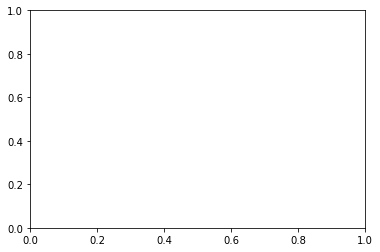

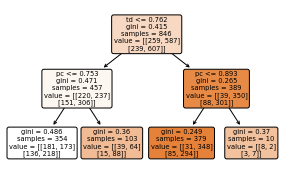

 58%|█████████████████████████                  | 52/89 [00:17<00:12,  2.86it/s]

52
Node_1
(354, 19)
(153, 19)
LR Model
153
153
Node_2
(103, 19)
(50, 19)
LR Model
203
203
Node_3
(379, 19)
(209, 19)
LR Model
412
412
Node_4
(10, 19)
(12, 19)
LR Model
424
424
240_714
Assay:  241_715
Inactive Compounds  1473
Active Compounds  491
Inactive Compounds (after Undersamplimg)  491
Total Compounds (after Undersamplimg)  982
982
492
Herirachal model for training data


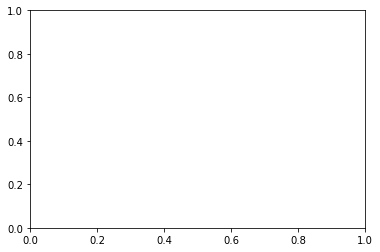

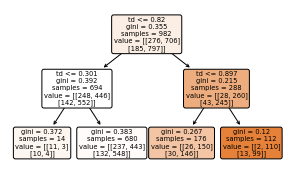

 60%|█████████████████████████▌                 | 53/89 [00:18<00:12,  2.83it/s]

53
Node_1
(14, 19)
(6, 19)
LR Model
6
6
Node_2
(680, 19)
(299, 19)
LR Model
305
305
Node_3
(176, 19)
(121, 19)
LR Model
426
426
Node_4
(112, 19)
(66, 19)
LR Model
492
492
241_715
Assay:  242_716
Inactive Compounds  703
Active Compounds  234
Inactive Compounds (after Undersamplimg)  234
Total Compounds (after Undersamplimg)  468
468
235
Herirachal model for training data


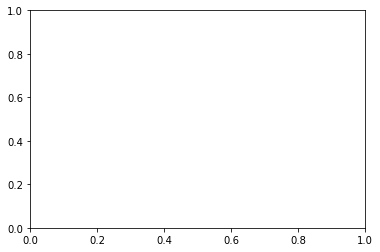

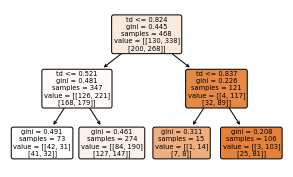

 61%|██████████████████████████                 | 54/89 [00:18<00:12,  2.84it/s]

54
Node_1
(73, 19)
(39, 19)
LR Model
39
39
Node_2
(274, 19)
(135, 19)
LR Model
174
174
Node_3
(15, 19)
(13, 19)
LR Model
187
187
Node_4
(106, 19)
(48, 19)
LR Model
235
235
242_716
Assay:  243_717
Inactive Compounds  386
Active Compounds  129
Inactive Compounds (after Undersamplimg)  129
Total Compounds (after Undersamplimg)  258
258
129
Herirachal model for training data


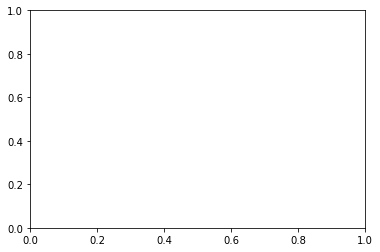

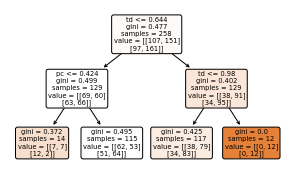

 62%|██████████████████████████▌                | 55/89 [00:18<00:11,  2.86it/s]

55
Node_1
(14, 19)
(7, 19)
LR Model
7
7
Node_2
(115, 19)
(52, 19)
LR Model
59
59
Node_3
(117, 19)
(67, 19)
LR Model
126
126
Node_4
(12, 19)
(3, 19)
only positive variables in train but test compounds present, take average:
243_717
Assay:  244_718
Inactive Compounds  187
Active Compounds  62
Inactive Compounds (after Undersamplimg)  62
Total Compounds (after Undersamplimg)  124
124
63
Herirachal model for training data


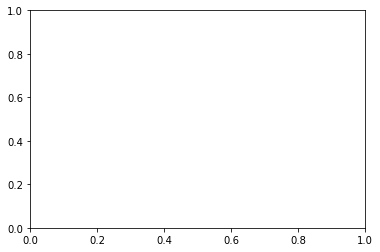

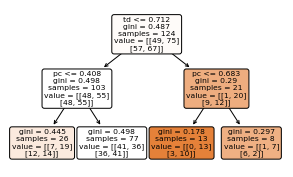

 63%|███████████████████████████                | 56/89 [00:19<00:11,  2.75it/s]

56
Node_1
(26, 19)
(10, 19)
LR Model
10
10
Node_2
(77, 19)
(36, 19)
LR Model
46
46
Node_3
(13, 19)
(9, 19)
LR Model
55
55
Node_4
(8, 19)
(8, 19)
LR Model
63
63
244_718
Assay:  245_719
Inactive Compounds  304
Active Compounds  102
Inactive Compounds (after Undersamplimg)  102
Total Compounds (after Undersamplimg)  204
204
102
Herirachal model for training data


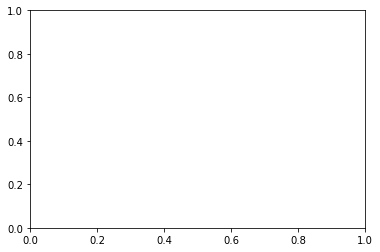

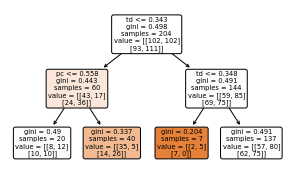

 64%|███████████████████████████▌               | 57/89 [00:19<00:11,  2.80it/s]

57
Node_1
(20, 19)
(6, 19)
LR Model
6
6
Node_2
(40, 19)
(11, 19)
LR Model
17
17
Node_3
(7, 19)
(2, 19)
LR Model
19
19
Node_4
(137, 19)
(83, 19)
LR Model
102
102
245_719
Assay:  246_720
Inactive Compounds  225
Active Compounds  75
Inactive Compounds (after Undersamplimg)  75
Total Compounds (after Undersamplimg)  150
150
76
Herirachal model for training data


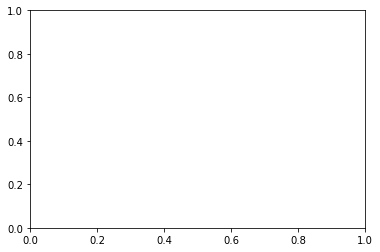

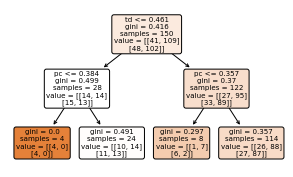

 65%|████████████████████████████               | 58/89 [00:19<00:10,  2.85it/s]

58
Node_1
(4, 19)
(1, 19)
only positive variables in train but test compounds present, take average:
Node_2
(24, 19)
(9, 19)
LR Model
10
10
Node_3
(8, 19)
(0, 19)
Node_4
(114, 19)
(66, 19)
LR Model
76
76
246_720
Assay:  247_721
Inactive Compounds  388
Active Compounds  130
Inactive Compounds (after Undersamplimg)  130
Total Compounds (after Undersamplimg)  260
260
130
Herirachal model for training data


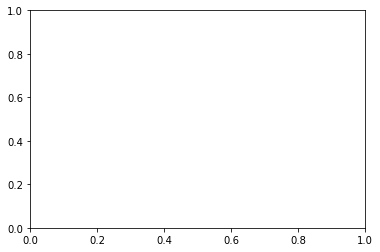

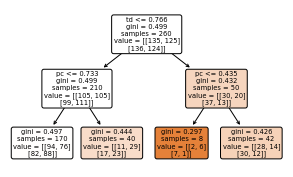

 66%|████████████████████████████▌              | 59/89 [00:20<00:10,  2.88it/s]

59
Node_1
(170, 19)
(75, 19)
LR Model
75
75
Node_2
(40, 19)
(14, 19)
LR Model
89
89
Node_3
(8, 19)
(5, 19)
LR Model
94
94
Node_4
(42, 19)
(36, 19)
LR Model
130
130
247_721
Assay:  248_722
Inactive Compounds  921
Active Compounds  307
Inactive Compounds (after Undersamplimg)  307
Total Compounds (after Undersamplimg)  614
614
308
Herirachal model for training data


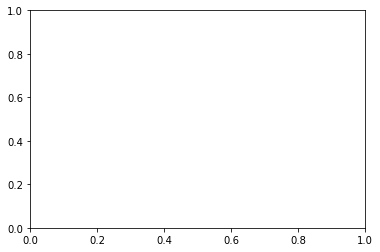

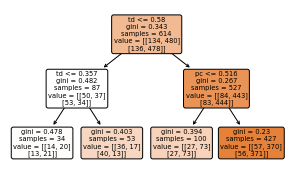

 67%|████████████████████████████▉              | 60/89 [00:20<00:10,  2.85it/s]

60
Node_1
(34, 19)
(19, 19)
LR Model
19
19
Node_2
(53, 19)
(28, 19)
LR Model
47
47
Node_3
(100, 19)
(36, 19)
LR Model
83
83
Node_4
(427, 19)
(225, 19)
LR Model
308
308
248_722
Assay:  249_724
Inactive Compounds  1380
Active Compounds  460
Inactive Compounds (after Undersamplimg)  460
Total Compounds (after Undersamplimg)  920
920
460
Herirachal model for training data


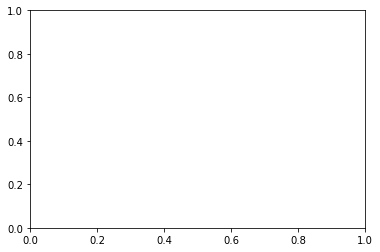

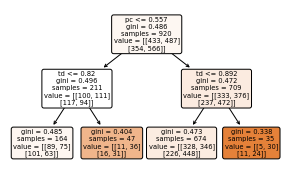

 69%|█████████████████████████████▍             | 61/89 [00:21<00:09,  2.83it/s]

61
Node_1
(164, 19)
(56, 19)
LR Model
56
56
Node_2
(47, 19)
(37, 19)
LR Model
93
93
Node_3
(674, 19)
(329, 19)
LR Model
422
422
Node_4
(35, 19)
(38, 19)
LR Model
460
460
249_724
Assay:  250_726
Inactive Compounds  108
Active Compounds  36
Inactive Compounds (after Undersamplimg)  36
Total Compounds (after Undersamplimg)  72
72
36
Herirachal model for training data


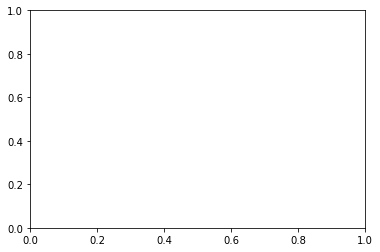

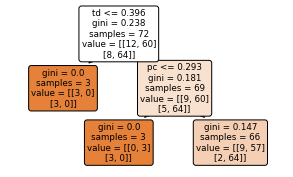

 70%|█████████████████████████████▉             | 62/89 [00:21<00:08,  3.03it/s]

62
Node_1
(3, 19)
(1, 19)
only positive variables in train but test compounds present, take average:
Node_2
(3, 19)
(0, 19)
1
1
Node_3
(66, 19)
(35, 19)
LR Model
36
36
Node_4
(0, 19)
(0, 19)
36
36
250_726
Assay:  251_727
Inactive Compounds  216
Active Compounds  72
Inactive Compounds (after Undersamplimg)  72
Total Compounds (after Undersamplimg)  144
144
72
Herirachal model for training data


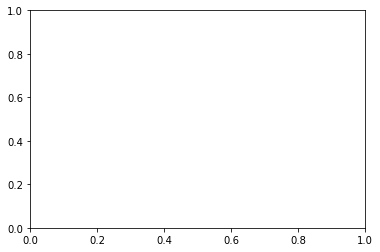

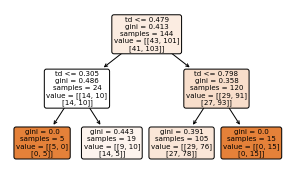

 71%|██████████████████████████████▍            | 63/89 [00:21<00:09,  2.86it/s]

63
Node_1
(5, 19)
(0, 19)
0
0
Node_2
(19, 19)
(2, 19)
LR Model
2
2
Node_3
(105, 19)
(64, 19)
LR Model
66
66
Node_4
(15, 19)
(6, 19)
LR Model
72
72
251_727
Assay:  253_729
Inactive Compounds  189
Active Compounds  63
Inactive Compounds (after Undersamplimg)  63
Total Compounds (after Undersamplimg)  126
126
64
Herirachal model for training data


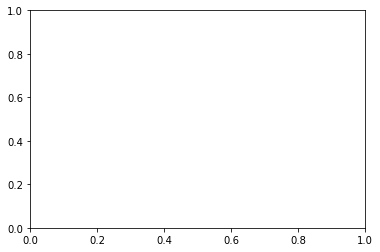

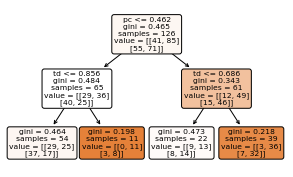

 72%|██████████████████████████████▉            | 64/89 [00:22<00:08,  2.87it/s]

64
Node_1
(54, 19)
(11, 19)
LR Model
11
11
Node_2
(11, 19)
(9, 19)
only negative variables in train but test compounds present, take average:
Node_3
(22, 19)
(11, 19)
LR Model
31
31
Node_4
(39, 19)
(33, 19)
LR Model
64
64
253_729
Assay:  257_735
Inactive Compounds  470
Active Compounds  157
Inactive Compounds (after Undersamplimg)  157
Total Compounds (after Undersamplimg)  314
314
157
Herirachal model for training data


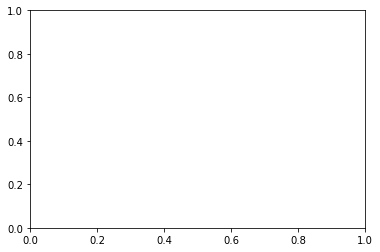

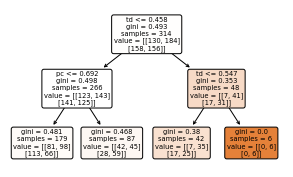

 73%|███████████████████████████████▍           | 65/89 [00:22<00:08,  2.89it/s]

65
Node_1
(179, 19)
(70, 19)
LR Model
70
70
Node_2
(87, 19)
(46, 19)
LR Model
116
116
Node_3
(42, 19)
(33, 19)
LR Model
149
149
Node_4
(6, 19)
(8, 19)
only negative variables in train but test compounds present, take average:
257_735
Assay:  259_737
Inactive Compounds  86
Active Compounds  29
Inactive Compounds (after Undersamplimg)  29
Total Compounds (after Undersamplimg)  58
58
29
Herirachal model for training data


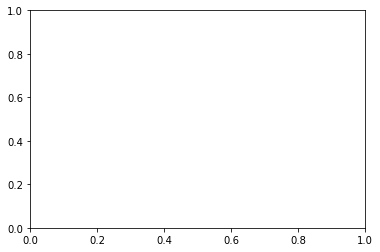

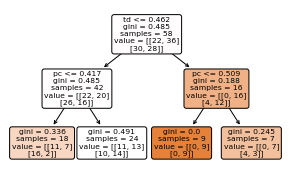

 74%|███████████████████████████████▉           | 66/89 [00:22<00:07,  2.93it/s]

66
Node_1
(18, 19)
(7, 19)
LR Model
7
7
Node_2
(24, 19)
(7, 19)
LR Model
14
14
Node_3
(9, 19)
(8, 19)
only negative variables in train but test compounds present, take average:
Node_4
(7, 19)
(7, 19)
only negative variables in train but test compounds present, take average:
259_737
Assay:  260_738
Inactive Compounds  1360
Active Compounds  454
Inactive Compounds (after Undersamplimg)  454
Total Compounds (after Undersamplimg)  908
908
454
Herirachal model for training data


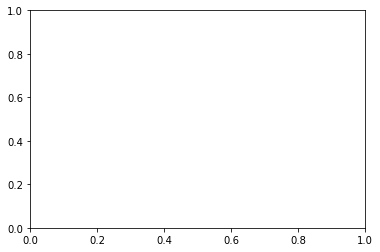

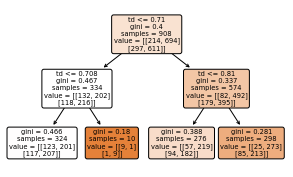

 75%|████████████████████████████████▎          | 67/89 [00:23<00:07,  2.92it/s]

67
Node_1
(324, 19)
(101, 19)
LR Model
101
101
Node_2
(10, 19)
(2, 19)
LR Model
103
103
Node_3
(276, 19)
(123, 19)
LR Model
226
226
Node_4
(298, 19)
(228, 19)
LR Model
454
454
260_738
Assay:  261_739
Inactive Compounds  657
Active Compounds  219
Inactive Compounds (after Undersamplimg)  219
Total Compounds (after Undersamplimg)  438
438
220
Herirachal model for training data


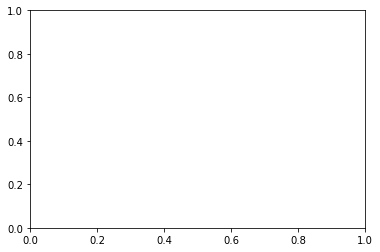

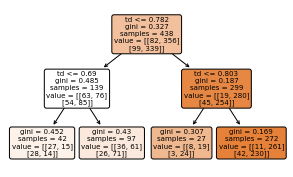

 76%|████████████████████████████████▊          | 68/89 [00:23<00:07,  2.92it/s]

68
Node_1
(42, 19)
(12, 19)
LR Model
12
12
Node_2
(97, 19)
(34, 19)
LR Model
46
46
Node_3
(27, 19)
(16, 19)
LR Model
62
62
Node_4
(272, 19)
(158, 19)
LR Model
220
220
261_739
Assay:  262_740
Inactive Compounds  105
Active Compounds  35
Inactive Compounds (after Undersamplimg)  35
Total Compounds (after Undersamplimg)  70
70
36
Herirachal model for training data


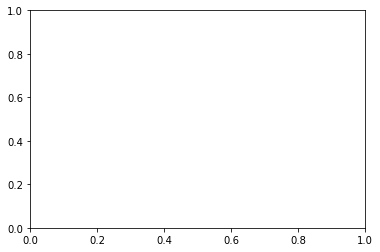

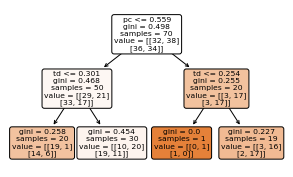

 78%|█████████████████████████████████▎         | 69/89 [00:23<00:06,  2.93it/s]

69
Node_1
(20, 19)
(8, 19)
LR Model
8
8
Node_2
(30, 19)
(14, 19)
LR Model
22
22
Node_3
(1, 19)
(0, 19)
22
22
Node_4
(19, 19)
(14, 19)
LR Model
36
36
262_740
Assay:  263_741
Inactive Compounds  324
Active Compounds  108
Inactive Compounds (after Undersamplimg)  108
Total Compounds (after Undersamplimg)  216
216
108
Herirachal model for training data


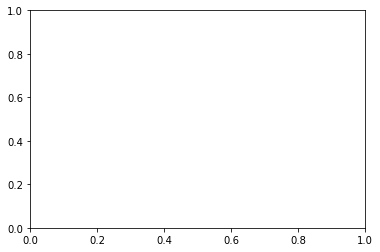

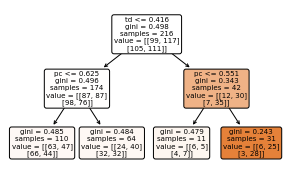

 79%|█████████████████████████████████▊         | 70/89 [00:24<00:06,  2.76it/s]

70
Node_1
(110, 19)
(29, 19)
LR Model
29
29
Node_2
(64, 19)
(41, 19)
LR Model
70
70
Node_3
(11, 19)
(7, 19)
LR Model
77
77
Node_4
(31, 19)
(31, 19)
LR Model
108
108
263_741
Assay:  264_742
Inactive Compounds  88
Active Compounds  30
Inactive Compounds (after Undersamplimg)  30
Total Compounds (after Undersamplimg)  60
60
30
Herirachal model for training data


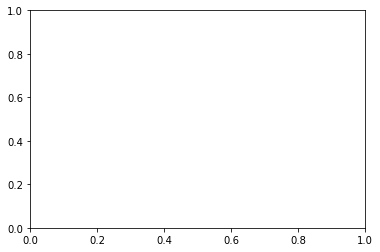

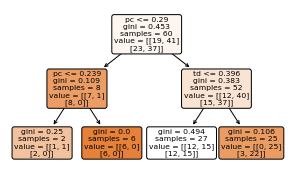

 80%|██████████████████████████████████▎        | 71/89 [00:24<00:06,  2.84it/s]

71
Node_1
(2, 19)
(2, 19)
only positive variables in train but test compounds present, take average:
Node_2
(6, 19)
(2, 19)
only positive variables in train but test compounds present, take average:
Node_3
(27, 19)
(8, 19)
LR Model
12
12
Node_4
(25, 19)
(18, 19)
only negative variables in train but test compounds present, take average:
264_742
Assay:  265_743
Inactive Compounds  1838
Active Compounds  613
Inactive Compounds (after Undersamplimg)  613
Total Compounds (after Undersamplimg)  1226
1226
613
Herirachal model for training data


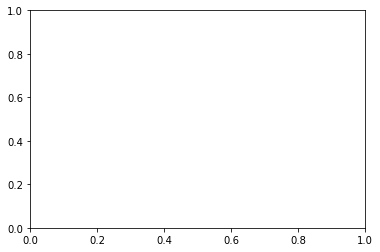

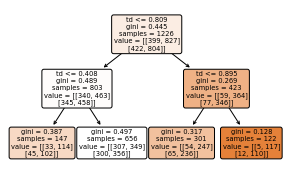

 81%|██████████████████████████████████▊        | 72/89 [00:24<00:06,  2.81it/s]

72
Node_1
(147, 19)
(48, 19)
LR Model
48
48
Node_2
(656, 19)
(300, 19)
LR Model
348
348
Node_3
(301, 19)
(180, 19)
LR Model
528
528
Node_4
(122, 19)
(85, 19)
LR Model
613
613
265_743
Assay:  266_744
Inactive Compounds  417
Active Compounds  139
Inactive Compounds (after Undersamplimg)  139
Total Compounds (after Undersamplimg)  278
278
140
Herirachal model for training data


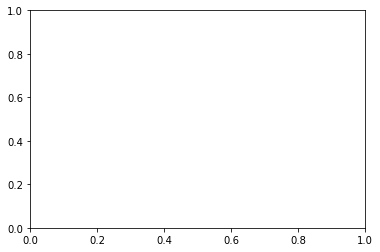

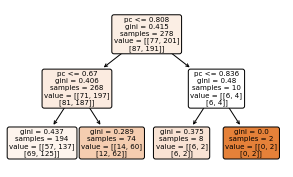

 82%|███████████████████████████████████▎       | 73/89 [00:25<00:05,  2.87it/s]

73
Node_1
(194, 19)
(87, 19)
LR Model
87
87
Node_2
(74, 19)
(43, 19)
LR Model
130
130
Node_3
(8, 19)
(6, 19)
LR Model
136
136
Node_4
(2, 19)
(4, 19)
only negative variables in train but test compounds present, take average:
266_744
Assay:  267_745
Inactive Compounds  544
Active Compounds  182
Inactive Compounds (after Undersamplimg)  182
Total Compounds (after Undersamplimg)  364
364
182
Herirachal model for training data


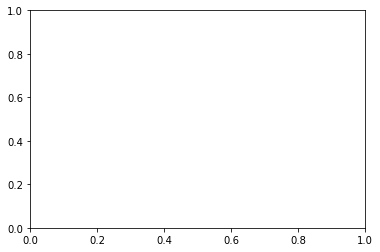

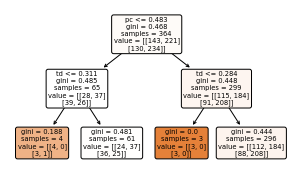

 83%|███████████████████████████████████▊       | 74/89 [00:25<00:05,  2.90it/s]

74
Node_1
(4, 19)
(4, 19)
only positive variables in train but test compounds present, take average:
Node_2
(61, 19)
(36, 19)
LR Model
40
40
Node_3
(3, 19)
(1, 19)
only positive variables in train but test compounds present, take average:
Node_4
(296, 19)
(141, 19)
LR Model
182
182
267_745
Assay:  268_746
Inactive Compounds  952
Active Compounds  318
Inactive Compounds (after Undersamplimg)  318
Total Compounds (after Undersamplimg)  636
636
318
Herirachal model for training data


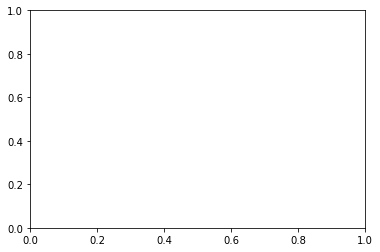

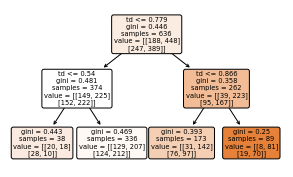

 84%|████████████████████████████████████▏      | 75/89 [00:25<00:04,  2.88it/s]

75
Node_1
(38, 19)
(4, 19)
LR Model
4
4
Node_2
(336, 19)
(170, 19)
LR Model
174
174
Node_3
(173, 19)
(90, 19)
LR Model
264
264
Node_4
(89, 19)
(54, 19)
LR Model
318
318
268_746
Assay:  269_747
Inactive Compounds  1454
Active Compounds  485
Inactive Compounds (after Undersamplimg)  485
Total Compounds (after Undersamplimg)  970
970
485
Herirachal model for training data


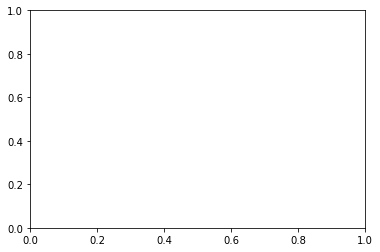

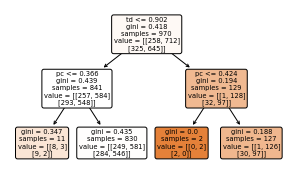

 85%|████████████████████████████████████▋      | 76/89 [00:26<00:04,  2.90it/s]

76
Node_1
(11, 19)
(1, 19)
only positive variables in train but test compounds present, take average:
Node_2
(830, 19)
(414, 19)
LR Model
415
415
Node_3
(2, 19)
(3, 19)
only positive variables in train but test compounds present, take average:
Node_4
(127, 19)
(67, 19)
LR Model
485
485
269_747
Assay:  270_748
Inactive Compounds  259
Active Compounds  86
Inactive Compounds (after Undersamplimg)  86
Total Compounds (after Undersamplimg)  172
172
87
Herirachal model for training data


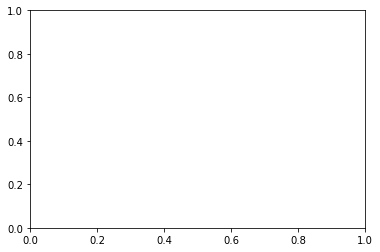

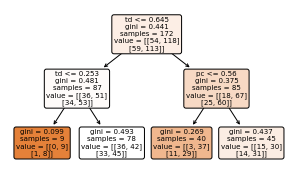

 87%|█████████████████████████████████████▏     | 77/89 [00:26<00:04,  2.77it/s]

77
Node_1
(9, 19)
(2, 19)
LR Model
2
2
Node_2
(78, 19)
(37, 19)
LR Model
39
39
Node_3
(40, 19)
(24, 19)
LR Model
63
63
Node_4
(45, 19)
(24, 19)
LR Model
87
87
270_748
Assay:  271_749
Inactive Compounds  568
Active Compounds  190
Inactive Compounds (after Undersamplimg)  190
Total Compounds (after Undersamplimg)  380
380
190
Herirachal model for training data


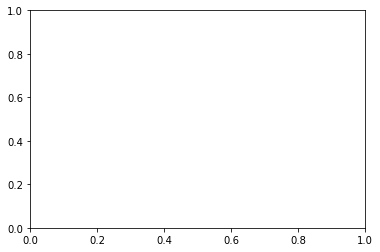

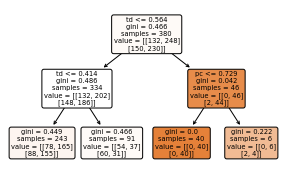

 88%|█████████████████████████████████████▋     | 78/89 [00:26<00:03,  2.82it/s]

78
Node_1
(243, 19)
(89, 19)
LR Model
89
89
Node_2
(91, 19)
(61, 19)
LR Model
150
150
Node_3
(40, 19)
(36, 19)
only negative variables in train but test compounds present, take average:
Node_4
(6, 19)
(4, 19)
only negative variables in train but test compounds present, take average:
271_749
Assay:  272_750
Inactive Compounds  184
Active Compounds  62
Inactive Compounds (after Undersamplimg)  62
Total Compounds (after Undersamplimg)  124
124
62
Herirachal model for training data


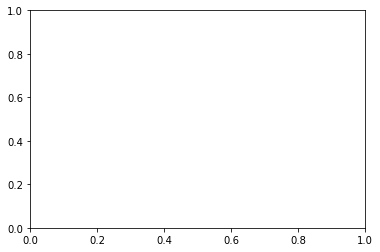

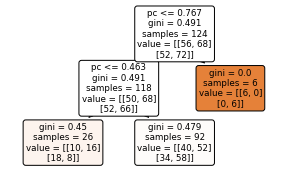

 89%|██████████████████████████████████████▏    | 79/89 [00:27<00:03,  3.01it/s]

79
Node_1
(26, 19)
(11, 19)
LR Model
11
11
Node_2
(92, 19)
(47, 19)
LR Model
58
58
Node_3
(6, 19)
(4, 19)
LR Model
62
62
Node_4
(0, 19)
(0, 19)
62
62
272_750
Assay:  273_751
Inactive Compounds  108
Active Compounds  36
Inactive Compounds (after Undersamplimg)  36
Total Compounds (after Undersamplimg)  72
72
36
Herirachal model for training data


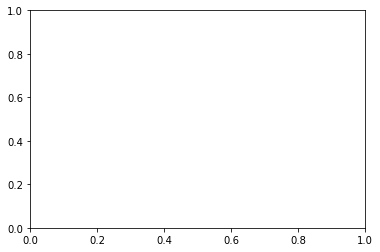

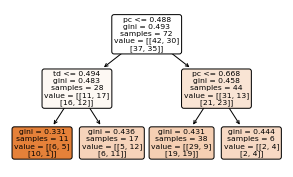

 90%|██████████████████████████████████████▋    | 80/89 [00:27<00:03,  2.99it/s]

80
Node_1
(11, 19)
(6, 19)
LR Model
6
6
Node_2
(17, 19)
(11, 19)
LR Model
17
17
Node_3
(38, 19)
(12, 19)
LR Model
29
29
Node_4
(6, 19)
(7, 19)
LR Model
36
36
273_751
Assay:  274_752
Inactive Compounds  256
Active Compounds  86
Inactive Compounds (after Undersamplimg)  86
Total Compounds (after Undersamplimg)  172
172
86
Herirachal model for training data


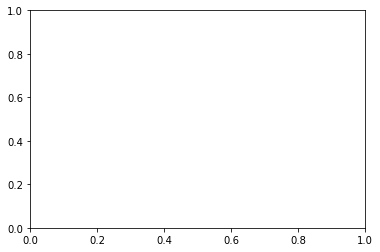

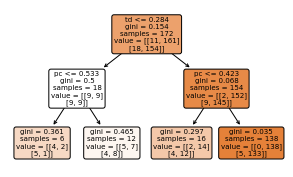

 91%|███████████████████████████████████████▏   | 81/89 [00:27<00:02,  2.98it/s]

81
Node_1
(6, 19)
(2, 19)
LR Model
2
2
Node_2
(12, 19)
(4, 19)
only positive variables in train but test compounds present, take average:
Node_3
(16, 19)
(12, 19)
LR Model
18
18
Node_4
(138, 19)
(68, 19)
LR Model
86
86
274_752
Assay:  275_753
Inactive Compounds  93
Active Compounds  31
Inactive Compounds (after Undersamplimg)  31
Total Compounds (after Undersamplimg)  62
62
32
Herirachal model for training data


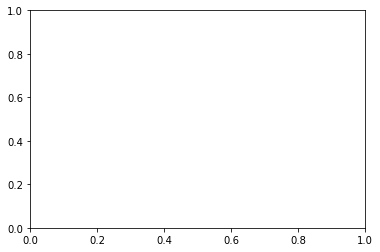

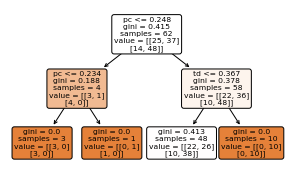

 92%|███████████████████████████████████████▌   | 82/89 [00:28<00:02,  3.00it/s]

82
Node_1
(3, 19)
(0, 19)
0
0
Node_2
(1, 19)
(0, 19)
0
0
Node_3
(48, 19)
(23, 19)
LR Model
23
23
Node_4
(10, 19)
(9, 19)
only negative variables in train but test compounds present, take average:
275_753
Assay:  275_754
Inactive Compounds  252
Active Compounds  84
Inactive Compounds (after Undersamplimg)  84
Total Compounds (after Undersamplimg)  168
168
84
Herirachal model for training data


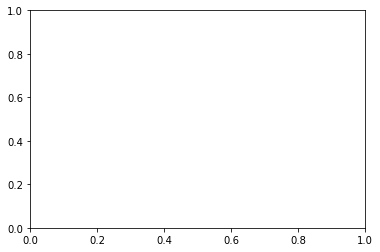

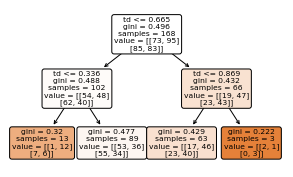

 93%|████████████████████████████████████████   | 83/89 [00:28<00:01,  3.01it/s]

83
Node_1
(13, 19)
(10, 19)
only positive variables in train but test compounds present, take average:
Node_2
(89, 19)
(28, 19)
LR Model
38
38
Node_3
(63, 19)
(43, 19)
LR Model
81
81
Node_4
(3, 19)
(3, 19)
only negative variables in train but test compounds present, take average:
275_754
Assay:  276_755
Inactive Compounds  336
Active Compounds  112
Inactive Compounds (after Undersamplimg)  112
Total Compounds (after Undersamplimg)  224
224
112
Herirachal model for training data


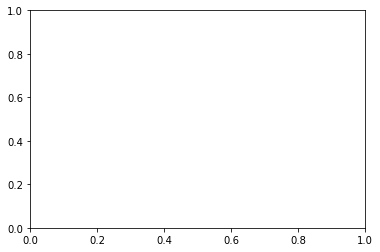

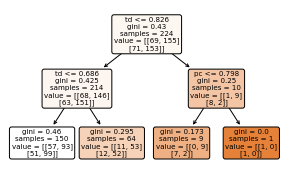

 94%|████████████████████████████████████████▌  | 84/89 [00:28<00:01,  2.86it/s]

84
Node_1
(150, 19)
(55, 19)
LR Model
55
55
Node_2
(64, 19)
(42, 19)
LR Model
97
97
Node_3
(9, 19)
(13, 19)
LR Model
110
110
Node_4
(1, 19)
(2, 19)
only negative variables in train but test compounds present, take average:
276_755
Assay:  278_757
Inactive Compounds  904
Active Compounds  302
Inactive Compounds (after Undersamplimg)  302
Total Compounds (after Undersamplimg)  604
604
302
Herirachal model for training data


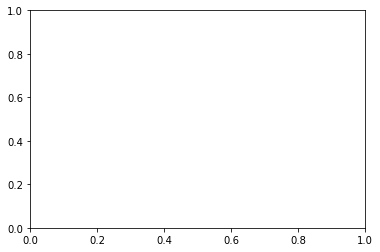

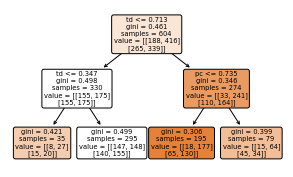

 96%|█████████████████████████████████████████  | 85/89 [00:29<00:01,  2.85it/s]

85
Node_1
(35, 19)
(16, 19)
LR Model
16
16
Node_2
(295, 19)
(110, 19)
LR Model
126
126
Node_3
(195, 19)
(119, 19)
LR Model
245
245
Node_4
(79, 19)
(57, 19)
LR Model
302
302
278_757
Assay:  279_758
Inactive Compounds  158
Active Compounds  53
Inactive Compounds (after Undersamplimg)  53
Total Compounds (after Undersamplimg)  106
106
53
Herirachal model for training data


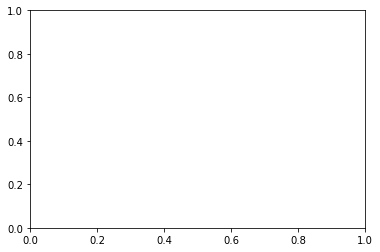

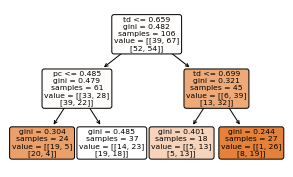

 97%|█████████████████████████████████████████▌ | 86/89 [00:29<00:01,  2.88it/s]

86
Node_1
(24, 19)
(9, 19)
LR Model
9
9
Node_2
(37, 19)
(15, 19)
LR Model
24
24
Node_3
(18, 19)
(10, 19)
LR Model
34
34
Node_4
(27, 19)
(19, 19)
LR Model
53
53
279_758
Assay:  280_759
Inactive Compounds  324
Active Compounds  108
Inactive Compounds (after Undersamplimg)  108
Total Compounds (after Undersamplimg)  216
216
108
Herirachal model for training data


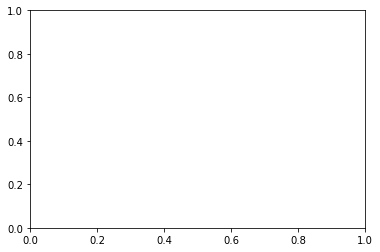

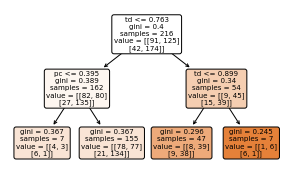

 98%|██████████████████████████████████████████ | 87/89 [00:29<00:00,  2.89it/s]

87
Node_1
(7, 19)
(7, 19)
LR Model
7
7
Node_2
(155, 19)
(77, 19)
LR Model
84
84
Node_3
(47, 19)
(20, 19)
LR Model
104
104
Node_4
(7, 19)
(4, 19)
LR Model
108
108
280_759
Assay:  283_762
Inactive Compounds  256
Active Compounds  86
Inactive Compounds (after Undersamplimg)  86
Total Compounds (after Undersamplimg)  172
172
86
Herirachal model for training data


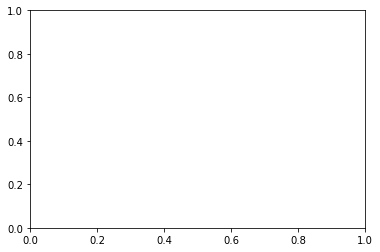

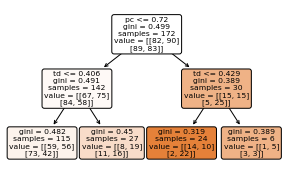

 99%|██████████████████████████████████████████▌| 88/89 [00:30<00:00,  2.84it/s]

88
Node_1
(115, 19)
(49, 19)
LR Model
49
49
Node_2
(27, 19)
(26, 19)
LR Model
75
75
Node_3
(24, 19)
(9, 19)
LR Model
84
84
Node_4
(6, 19)
(2, 19)
only negative variables in train but test compounds present, take average:
283_762
Assay:  93_259
Inactive Compounds  74
Active Compounds  27
Inactive Compounds (after Undersamplimg)  27
Total Compounds (after Undersamplimg)  54
54
26
Herirachal model for training data


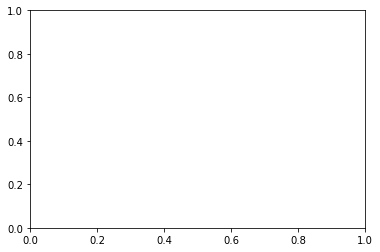

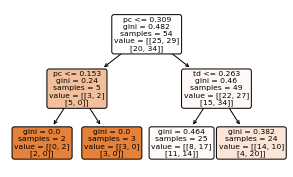

100%|███████████████████████████████████████████| 89/89 [00:30<00:00,  2.90it/s]

89
Node_1
(2, 19)
(0, 19)
0
0
Node_2
(3, 19)
(0, 19)
0
0
Node_3
(25, 19)
(3, 19)
LR Model
3
3
Node_4
(24, 19)
(23, 19)
LR Model
26
26
93_259


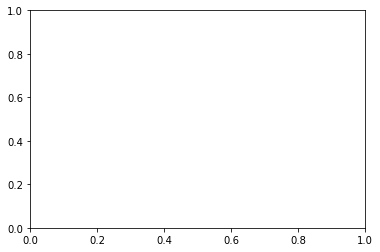

In [20]:
import warnings
warnings.filterwarnings("ignore") #ignore, default
import pandas

#sns.set(rc={'figure.figsize':(2, 2)})
#plt.rcParams['figure.dpi'] = 80
#sns.set_style("white")
metrics_list=[]
all_preds_test_compounds=pd.DataFrame(columns=['assay', 'InChICode_standardised', 'fp_proba', 'fp_pred', 'fp_threshold', 'CP_proba',
       'CP_pred', 'CP_threshold', 'true', 'ts', 'pc', 'Data', 'MFP_Correct',
       'CP_Correct', 'fp_proba_scaled', 'CP_proba_scaled', 'simple_pred',
       'Ensemble_Correct', 'merger_pred', 'merger_Correct'])

initializek()
#for assay in tqdm(assaylist[:7]):
for assay in tqdm(list_of_lists_df.assay.unique()[:]):
    
    print("Assay: ", assay)
    detail_list=pd.DataFrame()
    detail_list = list_of_lists_df[list_of_lists_df["assay"]==assay].reset_index(drop=True)
    detail_list_test = detail_list[detail_list["Data"]=="HeldOut"]

    #print("CP")
    check_heirarchial(assay, "CP", detail_list_test.true, detail_list_test.CP_pred, detail_list_test.CP_proba)
    #sns.scatterplot(data=detail_list[detail_list["true"]==1], x="pc", y="td", hue="CP_Correct", legend=False)
    #plt.show()
    
    #print("MFP")
    check_heirarchial(assay, "MFP", detail_list_test.true, detail_list_test.fp_pred, detail_list_test.fp_proba)
    #sns.scatterplot(data=detail_list[detail_list["true"]==1], x="pc", y="td", hue="MFP_Correct", legend=False)
    #plt.show()
    
    #print("Ensemble Averaged")
    check_heirarchial(assay, "Ensemble Averaged", detail_list_test.true, detail_list_test.simple_pred, detail_list_test.simple_pred)
    #sns.scatterplot(data=detail_list[detail_list["true"]==1], x="pc", y="td", hue="simple_pred", legend=False)
    #plt.show()
    
    #print("Distance Based Merger")
    merger_df=pd.DataFrame()
    
    StdInChI_batch, true_batch, pred_batch, proba_batch = RF_Fn(assay)
    check_heirarchial(assay, "Distance Based Merger", true_batch, pred_batch, proba_batch)
    
    #print(true_batch)
    
    print(assay)
    
    merger_df["InChICode_standardised"]=StdInChI_batch
    merger_df["merger_pred"]= pred_batch
    merger_df["true"]=true_batch
    merger_df["merger_Correct"]= merger_df["merger_pred"] == merger_df["true"]
    merger_df["assay"]=assay
    
    #.scatterplot(data=detail_list[detail_list["true"]==1], x="pc", y="td", hue="herrachial_Correct", legend=False)
    
    #For each assay combine original predictions and merger_df predictions
    #all_preds = pd.DataFrame()
    all_preds_test_compounds= pd.concat([all_preds_test_compounds, pd.merge(detail_list_test, merger_df)])

    
    
    
    

In [21]:
all_preds_test_compounds

,assay,InChICode_standardised,fp_proba,fp_pred,fp_threshold,CP_proba,CP_pred,CP_threshold,true,ts,pc,Data,MFP_Correct,CP_Correct,fp_proba_scaled,CP_proba_scaled,simple_pred,Ensemble_Correct,merger_pred,merger_Correct
0,178_684,InChI=1S/C24H28N4O4S/c1-14-12-28(15(2)13-29)24...,0.296817,0,0.325363,0.706426,1,0.240378,1.0,0.661017,0.731399,HeldOut,False,True,0.456133,0.806763,1.0,True,1.0,True
1,178_684,InChI=1S/C30H42ClN3O5S/c1-21-17-34(22(2)20-35)...,0.335199,1,0.325363,0.167642,0,0.240378,0.0,0.735294,0.447463,HeldOut,False,True,0.507290,0.348705,0.0,True,1.0,False
2,178_684,InChI=1S/C25H35N3O5S/c1-17-10-12-20(13-11-17)3...,0.110413,0,0.325363,0.190223,0,0.240378,0.0,0.785714,0.864848,HeldOut,True,True,0.169677,0.395675,0.0,True,0.0,True
3,178_684,InChI=1S/C31H42N4O6/c1-20-15-35(21(2)18-36)30(...,0.170428,0,0.325363,0.134469,0,0.240378,0.0,0.767123,0.750539,HeldOut,True,True,0.261904,0.279703,0.0,True,0.0,True
4,178_684,InChI=1S/C30H41N5O5/c1-20-17-35(21(2)19-36)28(...,0.231296,0,0.325363,0.079269,0,0.240378,1.0,0.591549,0.420531,HeldOut,False,False,0.355443,0.164885,0.0,False,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,93_259,"InChI=1S/C8H11ClN2O3S2/c1-4(2)16(13,14)5-3-15-...",0.309551,1,0.240921,0.322350,1,0.260921,0.0,0.250000,0.618373,HeldOut,False,False,0.545206,0.541558,1.0,False,1.0,False
22,93_259,InChI=1S/C18H23NO3/c1-13(12-22-17-6-4-3-5-7-17...,0.267934,1,0.240921,0.223786,0,0.260921,0.0,0.391304,0.603436,HeldOut,False,True,0.517793,0.428839,0.0,True,0.0,True
23,93_259,InChI=1S/C46H56N4O10/c1-7-42(55)22-28-23-45(40...,0.335675,1,0.240921,0.283991,1,0.260921,1.0,0.277778,0.826193,HeldOut,True,True,0.562413,0.515607,1.0,True,0.0,False
24,93_259,InChI=1S/C16H13N3O3/c1-22-16(21)19-15-17-12-8-...,0.334415,1,0.240921,0.371684,1,0.260921,0.0,0.344828,0.763229,HeldOut,False,False,0.561583,0.574934,1.0,False,0.0,True


In [22]:
all_preds_test_compounds.to_csv("Predictions_train_heldout_scaled_prob_all_assays_ensemble_merger_test_compounds.csv", index=False)

In [23]:
metrics_list = pd.DataFrame(metrics_list,columns=["assay","method","f1", "precision", "Sensitivity", "Specificity", "ba", "mcc", "AUC"])
metrics_list

,assay,method,f1,precision,Sensitivity,Specificity,ba,mcc,AUC
0,178_684,CP,0.606061,0.526316,0.714286,0.780488,0.747387,0.453246,0.754355
1,178_684,MFP,0.434783,0.555556,0.357143,0.902439,0.629791,0.305654,0.771777
2,178_684,Ensemble Averaged,0.583333,0.700000,0.500000,0.926829,0.713415,0.482063,0.713415
3,178_684,Distance Based Merger,0.727273,0.631579,0.857143,0.829268,0.843206,0.628800,0.872822
4,180_686,CP,0.588235,0.714286,0.500000,0.935484,0.717742,0.497009,0.777419
...,...,...,...,...,...,...,...,...,...
351,283_762,Distance Based Merger,0.571429,0.408163,0.952381,0.553846,0.753114,0.439251,0.734066
352,93_259,CP,0.470588,0.400000,0.571429,0.684211,0.627820,0.233074,0.578947
353,93_259,MFP,0.370370,0.250000,0.714286,0.210526,0.462406,-0.079156,0.586466
354,93_259,Ensemble Averaged,0.444444,0.363636,0.571429,0.631579,0.601504,0.182262,0.601504


In [24]:
metrics_list.to_csv("All_metrics.csv", index=False)